In [13]:
import sys, os
os.environ["CUDA_VISIBLE_DEVICES"] = '3'

if __package__ is None:
    import sys, os
    sys.path.append(os.path.realpath("../"))
from keras.layers import Input, GRU,RepeatVector
from keras.engine import Model
#from CMS_Deep_Learning.layers.ptr_net import Ptr_Layer
from CMS_Deep_Learning.layers.slice import Slice
from CMS_Deep_Learning.io import flatten
from keras import backend as K#,initializers
import numpy as np
import theano

def indx_to_transform(indicies):
    if len(indicies.shape) >= 2:
        indicies = indicies.tolist()
        was_list = True
    else:
        indicies = [indicies]
        was_list = False
    out = [np.eye(len(ind))[ind] for ind in indicies]
    return np.array(out) if was_list else out[0]
        
def to_transform(inp,truth):
    if(isinstance(truth,np.ndarray)):truth = truth.tolist()
    indicies = [truth.index(y) for y in inp]
    return np.eye(len(indicies))[indicies].T

In [14]:
#def giniSparsity(softmax_matrix, sparsity_coeff=.025):
#    return sparsity_coeff * K.sum(K.sum(K.sum(softmax_matrix*(1.0-softmax_matrix)))) / K.prod(K.shape(softmax_matrix)) 
#K.eval(giniSparsity(.002*np.random.random((100,100,100))) )

In [15]:
np.eye(2)/(.1*np.ones((1,1)))
K.backend()

u'theano'

In [16]:
from keras.engine.topology import Layer,initializations
from keras import backend as K#,initializers
from keras.regularizers import Regularizer
#import theano
#import tensorflow as tf 

def softmax(x, axis=-1):
    """Softmax activation function.
    # Arguments
        x : Tensor.
        axis: Integer, axis along which the softmax normalization is applied.
    # Returns
        Tensor, output of softmax transformation.
    # Raises
        ValueError: In case `dim(x) == 1`.
    """
    ndim = K.ndim(x)
    #if ndim == 2:
    #    return K.softmax(x)
    if ndim >= 2:
        e = K.exp(x - K.max(x, axis=axis, keepdims=True))
        s = K.sum(e, axis=axis, keepdims=True)
        return e / s
    else:
        raise ValueError('Cannot apply softmax to a tensor that is 1D')

def giniSparsity(softmax_matrix, sparsity_coeff=.025):
    return sparsity_coeff * K.sum(K.sum(K.sum(softmax_matrix*(1.0-softmax_matrix)))) / K.prod(K.cast((K.shape(softmax_matrix)),'float32')) 
#K.eval(giniSparsity(.002*np.random.random((100,100,100))) ) 

class Ptr_Layer(Layer):
    def __init__(self, attention_width,implementation='custom', seq_len=None,sparsity_coeff=1000.0, return_U=False,**kwargs):
       
        self.supports_masking = True
        self.init = initializations.get('glorot_uniform')
        self.attention_width = attention_width
        self.sparsity_coeff = sparsity_coeff
        self.implementation = implementation
        self.seq_len = seq_len
        self.return_U = return_U
        super(Ptr_Layer, self).__init__(**kwargs)

    def build(self, input_shape):
        print("IMPLEMENTATION: %r" % self.implementation)
        assert len(input_shape) >= 2
        
        if(self.implementation == 'custom' or self.implementation == 'custom_T'):
            assert self.attention_width == input_shape[1][-2], "attention width %r != seq size %r" %(self.attention_width,input_shape[1][-2])
        
        # self.attention_width = input_shape[1][-1]
        self.W1 = self.add_weight((self.attention_width ,input_shape[1][-1]), #(att_dim, recurrent_dim)
                                 initializer=self.init,
                                 name='{}_W1'.format(self.name))
        self.W2 = self.add_weight((self.attention_width ,input_shape[2][-1] if len(input_shape) > 2 else input_shape[1][-1]), #(att_dim, recurrent_dim)
                                  initializer=self.init,
                                  name='{}_W2'.format(self.name))
        if(self.implementation != 'custom' and self.implementation != 'custom_T'):
            self.v = self.add_weight((self.attention_width,1),
                                      initializer=self.init,
                                      name='{}_v'.format(self.name))
        

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        if(self.return_U):
            return [None,None]
        else:
            return None

    def call(self, inp, mask=None):
        assert isinstance(inp,list) and len(inp) >= 2, "Bad input expecting list of input,encoder,decoder"
        
        if(len(inp) == 3):
            x_T,e_T,d_T = inp
        elif(len(X) == 2):
            x_T,e_T = inp
            d_T = e_T
        
        #Let x be the inputs as column vectors
        # (batch_size ,sequence_len, feature_dim) -> (batch_size ,feature_dim,sequence_len)
        x = K.permute_dimensions(x_T,(0,2,1))
        
        
        if(K.backend() == "tensorflow"):
            assert self.seq_len != None, 'Must set Ptr_Layer(seq_len=?) if using Tensorflow'
            seq_len = self.seq_len
        else:
            seq_len = K.shape(e_T)[1]
        # Shape key:
        # x_T:  #(batch_size ,sequence_len, feature_dim)
        # e_T:  #(batch_size ,sequence_len, recurrent_dim)
        # d_T:  #(batch_size ,sequence_len, recurrent_dim)
        #*_T indicates row vectors
           
        #(batch_size ,sequence_len, recurrent_dim) * (recurrent_dim,att_dim) -> #(batch_size ,sequence_len,att_dim)
        _e_T, _d_T = K.dot(e_T,K.transpose(self.W1)), K.dot(d_T, K.transpose(self.W2)) # (batch_size ,sequence_len, att_dim)
        _e, _d = K.permute_dimensions(_e_T,(0,2,1)), K.permute_dimensions(_d_T,(0,2,1)) # (batch_size ,att_dim, sequence_len)
        #_e = theano.printing.Print('_e', attrs=['shape'])(_e)
        #_d = theano.printing.Print('_d', attrs=['shape'])(_d)
        
        def Tmap(fn, arrays, dtype='float32'):
            # assumes all arrays have same leading dim
            indices = K.range(K.shape(arrays[0])[0])
            out = K.map_fn(lambda ii: fn(*[array[ii] for array in arrays]), indices, dtype=dtype)
            return out
        
        
        
        if(self.implementation == 'ptr_net'):
            print("PTR_NET")
            
            E_T = K.repeat_elements(K.expand_dims(_e_T, dim=1), seq_len, axis=1) # (batch_size ,sequence_len, sequence_len, att_dim)
            D_T = K.repeat_elements(K.expand_dims(_d_T, dim=1), seq_len, axis=1) # (batch_size ,sequence_len, sequence_len, att_dim)

            D = K.permute_dimensions(D_T,(0,2,1,3)) # (batch_size ,sequence_len, sequence_len, att_dim)

            u = K.squeeze(K.dot(K.tanh(E_T + D),self.v),axis=-1) # (batch_size ,sequence_len, sequence_len)
            u = K.permute_dimensions(u, (0,2,1))
            #axis=2 is row axis therefore u*x has columns that are linear combos of x
            u = softmax(u,axis=2) # (batch_size ,sequence_len, sequence_len) 
        elif(self.implementation == 'ptr_net_scan'):
            def _ptr_net_u(_e_T,_d_T):
                __E_T = K.repeat_elements(K.expand_dims(_e_T, dim=0), seq_len, axis=0) # (sequence_len, sequence_len, att_dim)
                __D_T = K.repeat_elements(K.expand_dims(_d_T, dim=0), seq_len, axis=0) # (sequence_len, sequence_len, att_dim)


                __D = K.permute_dimensions(__D_T,(1,0,2)) # (sequence_len, sequence_len, att_dim)

                u = K.dot(K.tanh(__E_T + __D),self.v) # (sequence_len, sequence_len)
                u = K.squeeze(u,axis=-1)
                u = K.permute_dimensions(u, (1,0))
                u = softmax(u,axis=1) # (sequence_len, sequence_len) 

                return u
            assert K.backend()=='tensorflow', 'ptr_net_scan only works with theano backend'
            import tensorflow as tf
            u = tf.map_fn(lambda x: _ptr_net_u(x[0], x[1]), (_e_T,_d_T), dtype=tf.float32)
            
        elif(self.implementation == 'custom'):
            #only onto if att_dim == sequence_len
            u = _e + _d_T           ## (batch_size ,att_dim, att_dim)
            u = softmax(u,axis=2)   ## (batch_size ,att_dim, att_dim)  
        elif(self.implementation == 'custom_T'):
            #only onto if att_dim == sequence_len
            u = _e_T + _d           ## (batch_size ,att_dim, att_dim)
            u = softmax(u,axis=2)   ## (batch_size ,att_dim, att_dim)  
        else:
            raise ValueError("implementation not recognized: %r" % self.implementation)
            
        
        self.add_loss(giniSparsity(u,self.sparsity_coeff))
        
        u_T = K.permute_dimensions(u, (0, 2, 1))
        #For some reason batchdot dots the transposes (i.e batch_dot(X,Y) = X^TY^T = (YX)^T )
        #Therefore batch_dot(U^T,X) = UX^T -> X_sorted^T
        x_T = K.batch_dot(u_T,x, axes=[1, 2]) 
        
        #x_T = K.permute_dimensions(soft_sorted_x, (0, 2, 1))
        if(self.return_U):
            return [x_T, u] #+K.sum(K.sum(K.sum(u)))#+ K.sum(K.sum(K.sum(_e))) + K.sum(K.sum(K.sum(_d))) 
        else:
            return x_T

    def get_output_shape_for(self, input_shape):
        if(self.return_U):
            return [tuple(input_shape[0]),tuple((input_shape[0][0],input_shape[0][-2],input_shape[0][-2]))]
        else:
            return tuple(input_shape[0])
            





In [17]:
from keras.engine.topology import Layer,initializations
from keras import backend as K#,initializers
from keras.regularizers import Regularizer
import theano.tensor as T

def giniSparsity(softmax_matrix, sparsity_coeff=.02):
    return sparsity_coeff * K.sum(K.sum(K.sum(softmax_matrix*(1.0-softmax_matrix)))) / K.prod(K.cast((K.shape(softmax_matrix)),'float32')) 

def injectionRegulizer(softmax_matrix, injection_coeff=.02,axis=1):
    shape = K.cast(K.shape(softmax_matrix),'float32') 
    return injection_coeff * K.sum(K.sum(K.square(1.0-K.sum(softmax_matrix,axis=axis)))) / (shape[0]*shape[-1])

class WanderingGaussians(Layer):
    def __init__(self, seq_len,return_U=False,**kwargs):
        self.seq_len = seq_len
        self.init = initializations.get('glorot_uniform')
        self.return_U = return_U
        super(WanderingGaussians, self).__init__(**kwargs)

    def build(self, input_shape):
                
        self.W = self.add_weight((self.seq_len,input_shape[1][-1]), #(att_dim, recurrent_dim
                                 initializer=self.init,
                                 name='{}_W'.format(self.name))
        
        self.sigma = K.variable(np.ones((1,)))
        self.trainable_weights.append(self.sigma)
        #self.sigma = self.add_weight((1,1), #(att_dim, recurrent_dim
        #                         initializer=lambda x:
        #                         name='{}_sigma'.format(self.name))
        

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        if(self.return_U):
            return [None,None]
        else:
            return None

    def call(self, inp, mask=None):
        x_T,e_T = inp
        #e = K.permute_dimensions(e_T,(0,2,1))
        x = K.permute_dimensions(x_T,(0,2,1))
        
        g_centers = K.dot(e_T,self.W.T)
        g_centers = K.expand_dims(g_centers,dim=-1)
        
        #g_centers = theano.printing.Print('g_centers')(g_centers)
        
        locs = K.expand_dims(K.expand_dims(K.arange(self.seq_len)/float(self.seq_len),dim=0),dim=0)
        locs = K.repeat_elements(locs,self.seq_len,axis=1)
        locs = K.repeat_elements(locs,g_centers.shape[0],axis=0)
        diffs = locs - g_centers #(batch_size,seq_len, seq_len)
        #diffs = theano.printing.Print('diffs', attrs=['shape'])(diffs)
        
        sigma = K.repeat_elements(self.sigma,self.seq_len,axis=-1)
        #R = K.exp(-K.square(diffs)/sigma)
        R = (diffs*sigma)**-2#/(2.0*sigma))
        
        
        #u = R#K.square(R)
        u = softmax(R,axis=2)   ## (batch_size ,seq_len, seq_len)  
        u_T = K.permute_dimensions(u, (0, 2, 1))
        #For some reason batchdot dots the transposes (i.e batch_dot(X,Y) = X^TY^T = (YX)^T )
        #Therefore batch_dot(U^T,X) = UX^T -> X_sorted^T
        x_T = K.batch_dot(u_T,x, axes=[1, 2]) 
        #a = inp[0] + K.sum(K.sum(K.sum(diffs))) + K.sum(K.sum(self.sigma))
        return [x_T,u]
        
    def get_output_shape_for(self, input_shape):
        if(self.return_U):
            return [tuple(input_shape[0]),tuple((input_shape[0][0],input_shape[0][-2],input_shape[0][-2]))]
        else:
            return tuple(input_shape[0])
        

from keras.engine.topology import Layer,initializations
from keras import backend as K#,initializers
from keras.regularizers import Regularizer
import theano.tensor as T

class DotAndSoftmax(Layer):
    def __init__(self, return_U=False,sparsity_coeff=.000,injection_coeff=.000,apply_transposed=False,**kwargs):
        #self.seq_len = seq_len
        #self.init = initializations.get('glorot_uniform')
        self.injection_coeff =  injection_coeff
        self.return_U = return_U
        self.sparsity_coeff = sparsity_coeff
        self.apply_transposed = apply_transposed
        super(DotAndSoftmax, self).__init__(**kwargs)

    def build(self, input_shape):
        pass
        

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        if(self.return_U):
            return [None,None]
        else:
            return None

    def call(self, inp, mask=None):
        x_T,R = inp
        
        x = K.permute_dimensions(x_T,(0,2,1))
        
        u = softmax(R,axis= 1 if self.apply_transposed else 2)   ## (batch_size ,seq_len, seq_len)  
        #u = R / K.sum(R,axis=1,keepdims=True)
        self.add_loss(giniSparsity(u,self.sparsity_coeff))
        self.add_loss(injectionRegulizer(u,self.injection_coeff,axis = 2 if self.apply_transposed else 1))
        u_T = K.permute_dimensions(u, (0, 2, 1))
        #For some reason batchdot dots the transposes (i.e batch_dot(X,Y) = X^TY^T = (YX)^T )
        #Therefore batch_dot(U^T,X) = UX^T -> X_sorted^T
        x_T = K.batch_dot(u_T,x, axes=[1, 2]) 
        #a = inp[0] + K.sum(K.sum(K.sum(diffs))) + K.sum(K.sum(self.sigma))
        return [x_T,u]
        
    def get_output_shape_for(self, input_shape):
        if(self.return_U):
            return [tuple(input_shape[0]),tuple((input_shape[0][0],input_shape[0][-2],input_shape[0][-2]))]
        else:
            return tuple(input_shape[0])

        
def sort4_vec(inp):
    a,b,c,d = inp[:,0:1],inp[:,1:2],inp[:,2:3],inp[:,3:4]
    e,f = K.minimum(a,b),K.maximum(a,b) 
    g,h = K.minimum(c,d),K.maximum(c,d) 
    a_,p = K.minimum(e,g),K.maximum(e,g) 
    q,d_ = K.minimum(h,f),K.maximum(h,f) 
    b_,c_ = K.minimum(p,q),K.maximum(p,q) 
    return K.concatenate([a_,b_,c_,d_],axis=-1)

def sort8_vec(inp):
    a1_4,a5_8 = inp[:,0:4],inp[:,4:8]
    a1_4 = sort4_vec(a1_4)
    a5_8 = sort4_vec(a5_8)
    a1_2,a3_4 = a1_4[:,0:2],a1_4[:,2:4]
    a5_6,a7_8 = a5_8[:,0:2],a5_8[:,2:4]
    
    b1_4 = sort4_vec(K.concatenate([a1_2,a5_6],axis=-1))
    b5_8 = sort4_vec(K.concatenate([a3_4,a7_8],axis=-1))
    b1_2, b3_4 = b1_4[:,0:2],b1_4[:,2:4]
    b5_6, b7_8 = b5_8[:,0:2],b5_8[:,2:4]
    
    c3_6 = sort4_vec(K.concatenate([b3_4,b5_6],axis=-1))
    
    return K.concatenate([b1_2,c3_6,b7_8],axis=-1)

def sort4(a,b,c,d):
    
    e,f = K.minimum(a,b),K.maximum(a,b) 
    g,h = K.minimum(c,d),K.maximum(c,d) 
    a_,p = K.minimum(e,g),K.maximum(e,g) 
    q,d_ = K.minimum(h,f),K.maximum(h,f) 
    b_,c_ = K.minimum(p,q),K.maximum(p,q) 
    return a_,b_,c_,d_



def sort2(a,b): 
    a_,b_ = K.minimum(a,b),K.maximum(a,b) 
    return a_,b_

def sort3(a,b,c): 
    e,f = K.minimum(a,b),K.maximum(a,b) 
    g,c_ = K.minimum(f,c),K.maximum(f,c) 
    a_,b_ = K.minimum(e,g),K.maximum(e,g) 
    return a_,b_
    
class Sort4(Layer):
    def __init__(self, **kwargs):
        super(Sort4, self).__init__(**kwargs)

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, inp, mask=None):
        a,b,c,d = inp[:,0:1],inp[:,1:2],inp[:,2:3],inp[:,3:4]
        _a,_b,_c,_d = sort4(a,b,c,d)
        return K.concatenate([_a,_b,_c,_d],axis=-1)
        
    def get_output_shape_for(self, input_shape):
        return input_shape
    
class SortN(Layer):
    def __init__(self, seq_len,**kwargs):
        self.seq_len = seq_len
        super(SortN, self).__init__(**kwargs)

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, inp, mask=None):
        #print(self.input_shape)
        n = self.seq_len#inp.shape[-1]
        
        def srt(lst):
            m = n // 8
        
            #lst = K.reshape(lst,(8,m))
            #lst = K.permute_dimensions(lst,[1,0])
            #lst = sort8_vec(lst)
            #lst = K.permute_dimensions(lst,[1,0])
            #lst = K.reshape(lst,(n,))
            
            lst = K.reshape(lst,(m,8))
            lst = sort8_vec(lst)
            lst = K.reshape(lst,(n,))
            
            
            '''
            l = []
            for i in range(m):
                subset = [x for x in range(i,n,m)]
                print(subset)
                sub = K.gather(lst, subset)
                #sub = theano.printing.Print('sub',attrs=['shape'])(sub)
                sub = sort4(sub[0],sub[1],sub[2],sub[3])
                sub = K.concatenate([x.reshape((1,1)) for x in sub],axis=-1)
                l.append(sub.reshape((4,1)))
            restructured = K.concatenate(l,axis=-1)
            lst = restructured.reshape((n,))
            #m = n // 4
            #lst = lst.reshape(m,4)
            l = []
            for i in range(0,n,4):
                subset = [x for x in range(i,i+4,1)]
                print(subset)
                sub = K.gather(lst, subset)
                #sub = theano.printing.Print('sub',attrs=['shape'])(sub)
                sub = sort4(sub[0],sub[1],sub[2],sub[3])
                sub = K.concatenate([x.reshape((1,1)) for x in sub],axis=-1)
                l.append(sub.reshape((1,4)))
            restructured = K.concatenate(l,axis=-2)
            '''
            
            
            
            
            return lst
        
        return K.map_fn(srt,inp)
            
            
    def get_output_shape_for(self, input_shape):
        return input_shape
        


In [27]:
class Aggregate(Layer):
    '''Strings together several layers to make them seem like one '''
    def __init__(self, layers,**kwargs):
        #self.seq_len = seq_len
        #self.init = initializations.get('glorot_uniform')
        self.layers = layers
        super(Aggregate, self).__init__(**kwargs)

    def build(self, input_shape):
        self.trainable_weights = []
        for l in self.layers:
            l.build(input_shape)
            input_shape = l.get_output_shape_for(input_shape)
            self.trainable_weights += l.trainable_weights
        self.built = True

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, inp, mask=None):
        x = inp
        for l in self.layers:
            x = l.call(x)
        return x
        
        
    def get_output_shape_for(self, input_shape):
        for l in self.layers:
            input_shape = l.get_output_shape_for(input_shape)
        return input_shape

class StrideApply(Layer):
    def __init__(self, layer, layer_input_size, seq_len, stride=2,trainable=False,**kwargs):
        #self.seq_len = seq_len
        #self.init = initializations.get('glorot_uniform')
        self.seq_len = seq_len
        self.layer = layer
        self.layer_input_size = layer_input_size
        self.stride = stride
        self.trainable = trainable
        super(StrideApply, self).__init__(**kwargs)

    def build(self, input_shape):
        #self.input_shape = input_shape
        self.layer.build((input_shape[0],) + (self.stride,) + input_shape[2:])
        if(self.trainable):
            self.trainable_weights = self.layer.trainable_weights
        self.built = True

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, inp, mask=None):
        #inp = theano.printing.Print("inp",attrs=['shape'])(inp)
        
        s = self.stride
        w = self.layer_input_size[1]
        #print(s,w)
        resolved =[]
        prev_slc = self.layer.call(inp[:,:w])
        
        #print(s,self.seq_len-w+s,s)
        for i in range(s,self.seq_len-w+s,s):
            #print("i",i)
            resolved += [prev_slc[:,:s]]
            #prev_slc = theano.printing.Print("prev_slc",attrs=['shape'])(prev_slc)\
            a = prev_slc[:,s:w]
            b = inp[:,i+w-s:i+w]
            #a = theano.printing.Print("a",attrs=['shape'])(a)
            #b = theano.printing.Print("b",attrs=['shape'])(b)
            slc = K.concatenate([a, b])
            #slc = theano.printing.Print("slc",attrs=['shape'])(slc)
            prev_slc = self.layer.call(slc)
        resolved += [prev_slc]
        #print(len(resolved))
        out =K.concatenate(resolved,axis=1)
        #out = theano.printing.Print("out",attrs=['shape'])(out)
        
        
        return out 
            
    def get_output_shape_for(self, input_shape):
        return input_shape
'''
def exp_to_batch(x,batch_size):
    shp = K.shape(x)
    x = K.tile(x,(1,batch_size))
    x = K.reshape(x,(-1,) + shp)
    return x
    
    
def idPads(w,front,back):
    #print(batch_size)
    inds_a = K.arange(front)#[i for i in range(front)]
    inds_b = K.arange(back) + front+w #[i for i in range(front+w,front+w+back)]
    #print(np.arange(front),np.arange(back)+ front+w)
    a = K.one_hot(inds_a, w+front+back)
    b = K.one_hot(inds_b, w+front+back)
    z0 = K.zeros((front,w))
    z1 = K.zeros((back,w))
    #print(a,b,z0,z1)
    return a,b,z0,z1
'''
def identityPadder(w,front,back):
    inds_a = K.arange(front)#[i for i in range(front)]
    inds_b = K.arange(back) + front+w #[i for i in range(front+w,front+w+back)]
    #print(np.arange(front),np.arange(back)+ front+w)
    a = K.one_hot(inds_a, w+front+back)
    b = K.one_hot(inds_b, w+front+back)
    a = K.transpose(a)
    b = K.transpose(b)
    z0 = K.zeros((front,w))
    z1 = K.zeros((back,w))
    def f(inp):
        #print(inp)
        u = inp 
        u = K.concatenate([z0,u,z1], axis=0)
        return K.concatenate([a,u,b],axis=-1)
    return f
    

    
class StrideSort(Layer):
    def __init__(self, layer, layer_input_size, seq_len, stride=2,trainable=False,offset=0,**kwargs):
        #self.seq_len = seq_len
        #self.init = initializations.get('glorot_uniform')
        self.seq_len = seq_len
        self.layer = layer
        self.layer_input_size = layer_input_size
        self.stride = stride
        self.offset = offset
        super(StrideSort, self).__init__(trainable=trainable,**kwargs)

    def build(self, input_shape):
        #self.input_shape = input_shape
        self.layer.build((input_shape[0],) + (self.stride,) + input_shape[2:])
        if(self.trainable):
            self.trainable_weights = self.layer.trainable_weights
        self.built = True

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return [None,None]
    
    
            
        
    import theano
    def call(self, inp, mask=None):
        #import theano
        #inp = theano.printing.Print("inp",attrs=['shape'])(inp)
        if(K.ndim(inp) == 3):
            inp = K.squeeze(inp,axis=-1)
        
        batch_size = K.shape(inp)[0]
        s = self.stride
        w = self.layer_input_size[1]
        o = self.offset
        #print(s,w)
        if(o == 0):
            resolved_x = []
        else:
            prev_x = inp[:,:o]
            #prev_x = theano.printing.Print("prev_x_0", attrs=['shape'])(prev_x)
            resolved_x = [prev_x]
        
        
        assert self.seq_len >= w+o, "Offset too large"
        prev_x,prev_u = self.layer.call(inp[:,o:w+o])
        prev_x = K.squeeze(prev_x,axis=-1)
        #prev_x = theano.printing.Print("prev_x_01", attrs=['shape'])(prev_x)
        
        #a,b,z0,z1 = idPads(w,0,self.seq_len-w)
        resolved_u = prev_u = K.map_fn(identityPadder(w,o,self.seq_len-o-w),prev_u)
        #prev_u = theano.printing.Print('prev_u_0')(prev_u)
        #print(resolved_u)
        #print(s,self.seq_len-w+s,s)
        for i in range(s+o,self.seq_len-w+s,s):
            if(i+w > self.seq_len):continue
            print("i",i)
            
            resolved_x += [prev_x[:,:s]]
            #prev_slc = theano.printing.Print("prev_slc",attrs=['shape'])(prev_slc)\
            a = prev_x[:,s:w]
            b = inp[:,i+w-s:i+w]
            #a = theano.printing.Print("a",attrs=['shape'])(a)
            #b = theano.printing.Print("b",attrs=['shape'])(b)
            x = K.concatenate([a, b])
            #slc = theano.printing.Print("slc",attrs=['shape'])(slc)
            prev_x,prev_u = self.layer.call(x)
            prev_x = K.squeeze(prev_x,axis=-1)
            #prev_x = theano.printing.Print("prev_x%r"%i, attrs=['shape'])(prev_x)
            
            #a,b,z0,z1 = idPads(w,i,self.seq_len-w-i)
            prev_u = K.map_fn(identityPadder(w,i,self.seq_len-w-i),prev_u) 
            
            #prev_u = theano.printing.Print('prev_u%r'%i)(prev_u)
            resolved_u = K.batch_dot(prev_u,resolved_u)
            #resolved_u = K.permute_dimensions(resolved_u,(0,2,1))
            #resolved_u = K.batch_dot(resolved_u,prev_u)
            #resolved_u = theano.printing.Print('resolved_u_res')(resolved_u)
        resolved_x += [prev_x]
        print("PRINT",i+w,self.seq_len)
        if(i+w < self.seq_len):
            resolved_x += [inp[:,i+w:self.seq_len]]
        x_out = K.concatenate(resolved_x,axis=1)
        #x_out = theano.printing.Print("X", attrs=['shape'])(x_out)
        u_out = resolved_u
        #print(x_out, u_out)
        
        #out = theano.printing.Print("out",attrs=['shape'])(out)
        
        
        return [x_out, u_out]#+K.sum(K.sum(K.sum(x_out)))]
    
    def get_output_shape_for(self, input_shape):
        return [input_shape,(input_shape[0],self.seq_len,self.seq_len)]

In [28]:
SEQ_LEN = 8
SEQ_WIDTH = 1
DATA_SHAPE =[None, SEQ_LEN, SEQ_WIDTH]

inp = np.random.randint(size=tuple([10000]+DATA_SHAPE[1:]),low=0,high=1000)/1000.0
inp_sort_indicies = np.argsort(inp[:, :, 0])
#inp_sort_indicies = np.argsort(np.linalg.norm(inp,axis=-1))
target = np.array([np.take(inp[i], inp_sort_indicies[i], axis=-2) for i in range(inp.shape[0])])
inp_t_target = indx_to_transform(inp_sort_indicies)

val = np.random.randint(size=tuple([10000]+DATA_SHAPE[1:]),low=0,high=1000)/1000.0
val_sort_indicies = np.argsort(val[:, :, 0])
#val_sort_indicies = np.argsort(np.linalg.norm(val,axis=-1))
val_target = np.array([np.take(val[i], val_sort_indicies[i], axis=-2) for i in range(val.shape[0])])
val_t_target = indx_to_transform(val_sort_indicies)

In [29]:
import tensorflow as tf
def applyTransform(inp):
    u,x_T = inp    
    x = K.permute_dimensions(x_T,(0,2,1))
    u_T = K.permute_dimensions(u, (0, 2, 1))
    x_T = K.batch_dot(u_T,x, axes=[1, 2]) 
    return x_T

import h5py,re
from keras import activations
class SortingDNN(Layer):
    def __init__(self, weight_path,activation='relu',harden_sort=True,trainable=False,return_sorted=False,**kwargs):
        #self.seq_len = seq_len
        #self.init = initializations.get('glorot_uniform')
        self.activation = activations.get(activation)
        self.weight_path = weight_path
        self.harden_sort =  harden_sort
        self.return_sorted = return_sorted
        self.DNN_weights = []
        #self.trainable = trainable
        
        with h5py.File(self.weight_path) as f:
            keys = sorted(f.keys(), key=lambda x:int(x) if x.isdigit() else 0.0)
            for dk in [k for k in keys if 'dense' in k]:
                g = f[dk]
                lks = g.keys()
                W_keys = [x for x in lks if "_W" in x]
                b_keys = [x for x in lks if "_b" in x]
                if(len(W_keys) != 1):
                    raise ValueError("wrong number of W \
                                     matricies expected 1, got %r" % len(W_keys))
                ws = (g[W_keys[0]][:],g[b_keys[0]][:] if len(b_keys) > 0 else None)
                self.DNN_weights.append(ws)
                print(ws[0].shape, ws[1].shape if not isinstance(ws[1],type(None)) else None)
                
        self.seq_len = int(np.sqrt(self.DNN_weights[-1][0].shape[1]))
        print(self.seq_len)
        
        super(SortingDNN, self).__init__(trainable=trainable,**kwargs)

    def build(self, input_shape):
        if(self.built):
            raise RuntimeError("Cannot resuse layer")
        self.DNN_weights = [(K.variable(w),K.variable(b) if not isinstance(b,type(None)) else None ) \
                            for w,b in self.DNN_weights]
        if(self.trainable):
            import itertools
            a = []
            for w,b in self.DNN_weights:
                a += [w,b] if not isinstance(b,type(None)) else [w]
            self.trainable_weights = a
        self.built = True
        #self.hardness = K.variable(0.1)
        #self.trainable_weights = [self.hardness]

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        if(self.return_sorted):
            return [None,None]
        else:
            return None

    def call(self, inp, mask=None):
        batch_size = K.shape(inp)[0]
        x = inp
        for j,(W,b) in enumerate(self.DNN_weights):
            x = K.dot(x, W)
            if not isinstance(b,type(None)):
                x += b
            if(j != len(self.DNN_weights)-1):
                x = self.activation(x)
        R = K.reshape(x,(batch_size,self.seq_len,self.seq_len))
        #if(self.harden_sort):
        
        #R = R**3
        
        u = softmax(R,axis=2)   ## (batch_size ,seq_len, seq_len)  
        #u += K.random_normal((batch_size,self.seq_len,self.seq_len),0.0,.1)
        if(self.harden_sort):
            #raise NotImplementedError('cant harden')
            #u_streched = u**2
            #u = (u_streched)/K.sum(u_streched,axis=1,keepdims=True)
            #u = softmax(R,axis=1)
            #epsilon = 1e-7
            #def maxZero(x):
            #    return .5*(x+K.abs(x))
            #u_m = K.stop_gradient(K.max(u,axis=2,keepdims=True)-epsilon)
            #u = maxZero(u-u_m)/epsilon
            #self.hardness = .9
            #u = u/K.stop_gradient(u_m)
            u_m =  K.max(u,axis=2,keepdims=True)
            u_hard = u*K.stop_gradient(2.0* K.sigmoid(1e10*(u-u_m))/u_m)
            u = u_hard
            #u += K.random_normal(u.shape,0.0,.01)
            #u = self.hardness*u_hard + (1.0-self.hardness)*u
            #u = 2.0*(u/u_m) * K.sigmoid((u-u_m))
            #u = K.maximum(u-u_m,0.0)/epsilon
            
            #u = u#//(.5*(x+1.0+K.abs(x-1.0)))
        if(self.return_sorted):
            inp_reshape = K.reshape(inp,(batch_size,self.seq_len,1))
            x_sorted = applyTransform([u,inp_reshape])
            return [x_sorted,u]
        else:
            return u
        #inp = theano.printing.Print("inp",attrs=['shape'])(inp)
        
    def get_output_shape_for(self, input_shape):
        if(self.return_sorted):
            return [input_shape,(input_shape[0],self.seq_len,self.seq_len)]
        else:
            return (input_shape[0],self.seq_len,self.seq_len)

In [ ]:

def deltaPos(x,epsilon=1e7):
    return (1/epsilon)*K.relu(-x+epsilon)

def deltaNeg(x,epsilon=1e7):
    return (1/epsilon)*K.relu(x+epsilon)

def netToOne(x):
    return deltaPos(K.relu(x))

def toSort(x,seq_len):
    ar = K.arange(seq_len)
    ar = K.expand_dims(ar,dim=-1)
    ar = K.expand_dims(ar,dim=0)
    return deltaPos( (ar - K.sum(negToOne(x)))**2 )

class SortingHard(Layer):
    def __init__(self, seq_len,return_sorted=True,**kwargs):
        self.return_sorted = return_sorted      
        self.seq_len = seq_len
        super(SortingHard, self).__init__(trainable=trainable,**kwargs)

    def build(self, input_shape)
        self.built = True

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        if(self.return_sorted):
            return [None,None]
        else:
            return None

    def call(self, inp, mask=None):
        batch_size = K.shape(inp)[0]
        
        if(K.ndim(inp) != 3):
            inp = K.expand_dims(inp,dim=-1)
        D = inp.repeat_elements(inp,self.seq_len,axis=-1)
        alpha = D - K.transpose(D)
        
        
        u = toSort(alpha)
        if(self.return_sorted):
            inp_reshape = K.reshape(inp,(batch_size,self.seq_len,1))
            x_sorted = applyTransform([u,inp_reshape])
            return [x_sorted,u]
        else:
            return u
        
    def get_output_shape_for(self, input_shape):
        if(self.return_sorted):
            return [input_shape,(input_shape[0],self.seq_len,self.seq_len)]
        else:
            return (input_shape[0],self.seq_len,self.seq_len)

In [30]:
from keras.engine.topology import Layer,initializations,Merge
from keras.layers import Convolution1D,MaxPooling1D,Flatten,Dense,Reshape,MaxPooling2D,TimeDistributed,Lambda
from keras.layers.convolutional import Conv1D,Conv2D
from keras.layers.advanced_activations import LeakyReLU
from keras import optimizers
def null_cost(y_true, y_pred):
    # output itself is cost and must be minimized
    return K.sum(y_pred)*0 + K.sum(y_true)*0



def buildModelConv(sparsity_coeff=0.0,injection_coeff=0.0):
    internal_fsize = 200
    
    x = Input(shape=(SEQ_LEN, SEQ_WIDTH ), name="input")
    c = Conv1D(internal_fsize, filter_length=2, activation='relu', border_mode='same')(x)
    f = Flatten()(c)
    d = Dense(SEQ_LEN*SEQ_LEN, activation='linear')(f)
    #m = MaxPooling1D(pool_length=2,stride=1,border_mode='same')(c)
    #r = Reshape(target_shape=(1,SEQ_LEN,internal_fsize))(m)
    #c = Conv2D(SEQ_LEN, 1,internal_fsize, activation='relu', border_mode='same')(r)
    #m = MaxPooling2D(pool_size=(2,2),strides=(1,1),border_mode='same')(c)
    #c = Conv2D(SEQ_LEN, 1,internal_fsize, activation='relu', border_mode='same')(m)
    #m = MaxPooling1D(border_mode='same')(c)
    
    r = Reshape(target_shape=(SEQ_LEN,SEQ_LEN))(d)
    p,u = DotAndSoftmax(sparsity_coeff=sparsity_coeff,injection_coeff=injection_coeff,return_U=True)([x,r])

    model = Model(input=x, output=[p,u], name='test')
    model.compile(optimizer='adam',loss=['mse',null_cost],loss_weights=[1., 0.0])
    #model = Model(input=x, output=p, name='test')
    #model.compile(optimizer='adam',loss='mse')
    return model

def buildGRUAttention(sparsity_coeff=0.0,injection_coeff=0.0):
    internal_fsize = 200
    
    x = Input(shape=(SEQ_LEN, SEQ_WIDTH ), name="input")
    c = Conv1D(internal_fsize, filter_length=2, activation='relu', border_mode='same')(x)
    f = Flatten()(c)
    d = Dense(SEQ_LEN*SEQ_LEN, activation='linear')(f)
    #m = MaxPooling1D(pool_length=2,stride=1,border_mode='same')(c)
    #r = Reshape(target_shape=(1,SEQ_LEN,internal_fsize))(m)
    #c = Conv2D(SEQ_LEN, 1,internal_fsize, activation='relu', border_mode='same')(r)
    #m = MaxPooling2D(pool_size=(2,2),strides=(1,1),border_mode='same')(c)
    #c = Conv2D(SEQ_LEN, 1,internal_fsize, activation='relu', border_mode='same')(m)
    #m = MaxPooling1D(border_mode='same')(c)
    
    r = Reshape(target_shape=(SEQ_LEN,SEQ_LEN))(d)
    p,u = DotAndSoftmax(sparsity_coeff=sparsity_coeff,injection_coeff=injection_coeff,return_U=True)([x,r])

    model = Model(input=x, output=[p,u], name='test')
    model.compile(optimizer='adam',loss=['mse',null_cost],loss_weights=[1., 0.0])
    #model = Model(input=x, output=p, name='test')
    #model.compile(optimizer='adam',loss='mse')
    return model

def buildModel(sparsity_coeff=0.0,injection_coeff=0.0):
    x = Input(shape=(SEQ_LEN, SEQ_WIDTH), name="input")
   # e = TimeDistributed(Dense(400,activation='relu'))(x)
   # e = TimeDistributed(Dense(400,activation='relu'))(e)
    #e = TimeDistributed(Dense(1,activation='relu'))(x)
    #agg = Aggregate([Dense(100,activation='relu'),Dense(100,activation='relu'),Dense(1,activation='relu')])
    #agg = Aggregate([Dense(1,activation='relu')])
    #e = TimeDistributed(agg)(x)
    e = Flatten()(x)
    e = Dense(800, activation='relu',name='dense_1')(e)
    e = Dense(800, activation='relu',name='dense_2')(e)
    e = Dense(800, activation='relu',name='dense_3')(e)
    #e = Dense(800, activation='relu')(e)
    #e = Dense(400, activation='relu')(e)
    e = Dense(SEQ_LEN*SEQ_LEN, activation='linear',name='dense_4')(e)
    #e = Lambda(lambda x: x ** 2)(e)
    print(e)
    r = Reshape(target_shape=(SEQ_LEN,SEQ_LEN))(e)
    p,u = DotAndSoftmax(sparsity_coeff=sparsity_coeff, injection_coeff=injection_coeff,return_U=True)([x,r])
    #p,u = DotAndSoftmax(sparsity_coeff=sparsity_coeff, apply_transposed=True,
    #                    injection_coeff=injection_coeff,return_U=True)([x,u])
    #e = Convolution1D(nb_filter=10, filter_length=5, activation='relu')(x)
    #e = MaxPooling1D()(e)     # Downsample the output of convolution by 2X.
    #e = Convolution1D(nb_filter=10, filter_length=3, activation='relu')(e)
    #e = MaxPooling1D()(e)
    #e = Flatten()(e)
    #e = Dense(100, activation='linear')(e)
    #e = GRU(100,return_sequences=False)(x)
    #s = Slice("[-1,:]")(e)
    # s = Slice('[-1,:]')(e)
    # s = theano.printing.Print("s")(s)
    #r = RepeatVector(SEQ_LEN)(s)
    #m = Merge(mode='concat',concat_axis=2)([r,x])
    #d = GRU(128,return_sequences=True)(m)
    #p,u = WanderingGaussians(SEQ_LEN,return_U=True)([x,e])

    model = Model(input=x, output=[p,u], name='test')
    model.compile(optimizer='adam',loss=['mse','mse'],loss_weights=[0.0, 1.0/float(SEQ_LEN)])
    #model = Model(input=x, output=p, name='test')
    #model.compile(optimizer='adam',loss='mse')
    return model



def buildPretrained():
    sys.setrecursionlimit(50000)
    strDNN = SortingDNN("/bigdata/shared/Delphes/sorter_weights/Best8_800x3.h5",harden_sort=False,trainable=False,return_sorted=True)
    strDNN2 = SortingDNN("/bigdata/shared/Delphes/sorter_weights/Best8_800x3.h5",harden_sort=False,trainable=False,return_sorted=True)
    strDNN3 = SortingDNN("/bigdata/shared/Delphes/sorter_weights/Best8_800x3.h5",harden_sort=False,trainable=False,return_sorted=True)
    
    x = Input(shape=(SEQ_LEN, SEQ_WIDTH), name="input")
    _,u = StrideSort(strDNN,layer_input_size=(100,8,1), seq_len=SEQ_LEN,stride=8,offset=0)(x)
    
    #m_srt = Lambda(lambda inp: applyTransform(inp), output_shape=(SEQ_LEN, SEQ_WIDTH))([u,x])
    #_,u2 = StrideSort(strDNN2,layer_input_size=(100,8,1), seq_len=SEQ_LEN,stride=8,offset=4)(m_srt)
    #u = Lambda(lambda x: K.batch_dot(u2,u),output_shape=(SEQ_LEN, SEQ_LEN))([u,u2])
    
    #m_srt = Reshape(target_shape=(SEQ_LEN, SEQ_WIDTH))(m_srt)
    #m_srt = Lambda(lambda inp: applyTransform(inp), output_shape=(SEQ_LEN, SEQ_WIDTH))([u2,m_srt])
    #_,u2 = StrideSort(strDNN3,layer_input_size=(100,8,1), seq_len=SEQ_LEN,stride=8,offset=0)(m_srt)
    #u = Lambda(lambda x: K.batch_dot(u2,u),output_shape=(SEQ_LEN, SEQ_LEN))([u,u2])
    
    
    
    #u = SortingDNN("/bigdata/shared/Delphes/sorter_weights/Best8_800x3.h5",harden_sort=False,trainable=False)(e)
    p = Lambda(lambda inp: applyTransform(inp), output_shape=(SEQ_LEN, SEQ_WIDTH))([u,x])
    
    #p = Reshape(target_shape=(SEQ_LEN, SEQ_WIDTH))(m_srt)
    model = Model(input=x, output=[p,u], name='test')
    #adam = optimizers.Adam(clipnorm=1.0)
    model.compile(optimizer='adam',loss=['mse','mse'],loss_weights=[1.0,0.0/float(SEQ_LEN)])
    return model

def buildLearnMetric():
    
    strDNN = SortingDNN("/bigdata/shared/Delphes/sorter_weights/Best8_800x3.h5",harden_sort=False,trainable=False,return_sorted=True)
    
    x = Input(shape=(SEQ_LEN, SEQ_WIDTH), name="input")
    
    agg = Aggregate([Dense(100,activation='relu'),Dense(100,activation='relu'),Dense(1,activation='sigmoid')])
     
    metric = TimeDistributed(agg)(x)
    metric_flat = Flatten()(metric)
    
    m_srt,u = StrideSort(strDNN,layer_input_size=(100,8,1), seq_len=SEQ_LEN,stride=8)(metric_flat)
    #metric_flat = Flatten()(m_srt)
    #m_srt,u2 = StrideSort(strDNN,layer_input_size=(100,8,1), seq_len=SEQ_LEN,stride=8,offset=4)(metric_flat)
    #u = Lambda(lambda x: K.batch_dot(u2,u))([u,u2])
    #p = Lambda(lambda inp: K.dot(inp[0],inp[1]), output_shape=(SEQ_LEN, SEQ_WIDTH))([u,x])
    p = Lambda(lambda inp: applyTransform(inp), output_shape=(SEQ_LEN, SEQ_WIDTH))([u,x])
    model = Model(input=x, output=[p,u,metric_flat], name='test')
    model.compile(optimizer='adam',loss=['mse','mse',null_cost],loss_weights=[1.0,0.0/float(SEQ_LEN),0.0])
    return model

def buildMetricModel(sparsity_coeff=0.0,injection_coeff=0.0):
    x = Input(shape=(SEQ_LEN, SEQ_WIDTH), name="input")
   # e = TimeDistributed(Dense(400,activation='relu'))(x)
   # e = TimeDistributed(Dense(400,activation='relu'))(e)
    #e = TimeDistributed(Dense(1,activation='relu'))(x)
    agg = Aggregate([Dense(100,activation='relu'),Dense(100,activation='relu'),Dense(1,activation='sigmoid')])
    #agg = Aggregate([Dense(1,activation='relu')])
    p = TimeDistributed(agg)(x)
    model = Model(input=x, output=p, name='test')
    model.compile(optimizer='adam',loss='mse')
    return model

In [31]:
np.set_printoptions(precision=4,suppress=True)


mode = 'lrnMod'
if(mode == "lrnSrt"):
    model = buildModel()
    t = [target,inp_t_target]
if(mode == "lrnMod"):
    model = buildLearnMetric()
    t = [target,inp_t_target,np.sum(target,axis=-1)]
elif(mode == 'pred'):
    model = buildPretrained()
    t = [target,inp_t_target]

print(model.summary())

for i in range(100):
    
    model.fit(inp, t, nb_epoch=1,batch_size=100)
    
    out = model.predict(val)
    p,u = out[0],out[1]
    val_mse = float(K.eval(K.mean(K.pow(p[:1] - val_target[:1], 2))))
    print("VAL_MSE:", val_mse)
    if(len(out) > 2):
        print("AVG CORRECT:",np.average(np.equal(np.argsort(out[2]), np.argsort(np.linalg.norm(val,axis=-1)),dtype='float')))
        



((8, 800), (800,))
((800, 800), (800,))
((800, 800), (800,))
((800, 64), (64,))
8


UnboundLocalError: local variable 'i' referenced before assignment

In [ ]:

print()

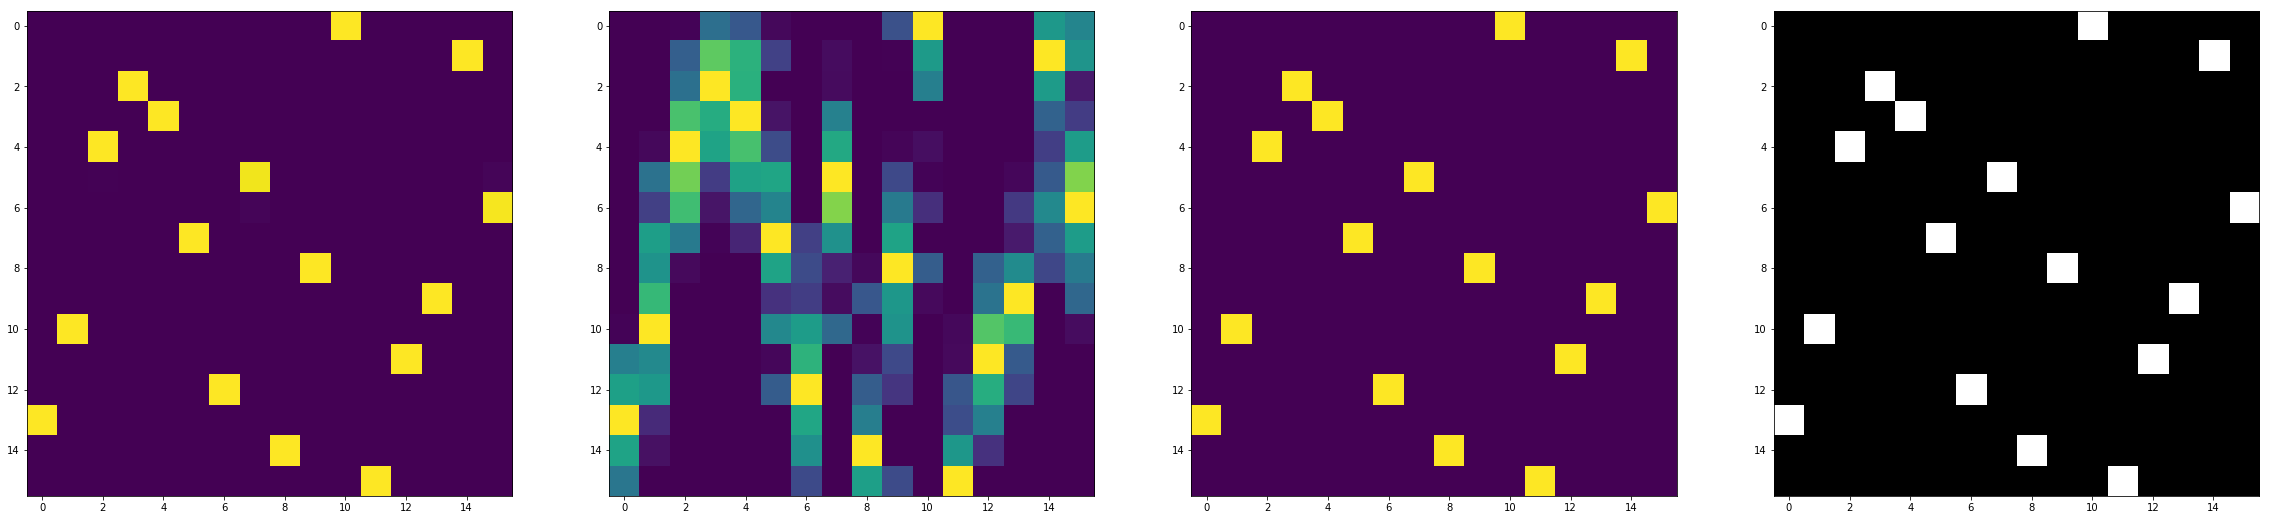

('INPUT:', [950.0, 761.0, 419.0, 349.0, 372.0, 552.0, 849.0, 459.0, 995.0, 634.0, 291.0, 998.0, 844.0, 727.0, 300.0, 469.0])
('PREDICT:', [291.0008850097656, 300.18426513671875, 349.00372314453125, 372.0618896484375, 418.94134521484375, 458.8431701660156, 468.8213806152344, 552.0091552734375, 633.9970092773438, 727.0155639648438, 761.1611328125, 844.0012817382812, 849.0022583007812, 949.9912109375, 994.9957275390625, 997.9998168945312])
('P_HARD:', [291.0, 300.0, 349.0, 372.0, 419.0, 459.0, 469.0, 552.0, 634.0, 727.0, 761.0, 844.0, 849.0, 950.0, 995.0, 998.0])
('TRUE   :', [291.0, 300.0, 349.0, 372.0, 419.0, 459.0, 469.0, 552.0, 634.0, 727.0, 761.0, 844.0, 849.0, 950.0, 995.0, 998.0])
0.619732764071
[ 1.4495  0.8428 -0.255  -0.4797 -0.4059  0.1719  1.1252 -0.1266  1.5939
  0.4351 -0.6659  1.6035  1.1092  0.7336 -0.637  -0.0945]
('METRIC:', array([0]))
('NORM:  ', array([10, 14,  3,  4,  2,  7, 15,  5,  9, 13,  1, 12,  6,  0,  8, 11]))


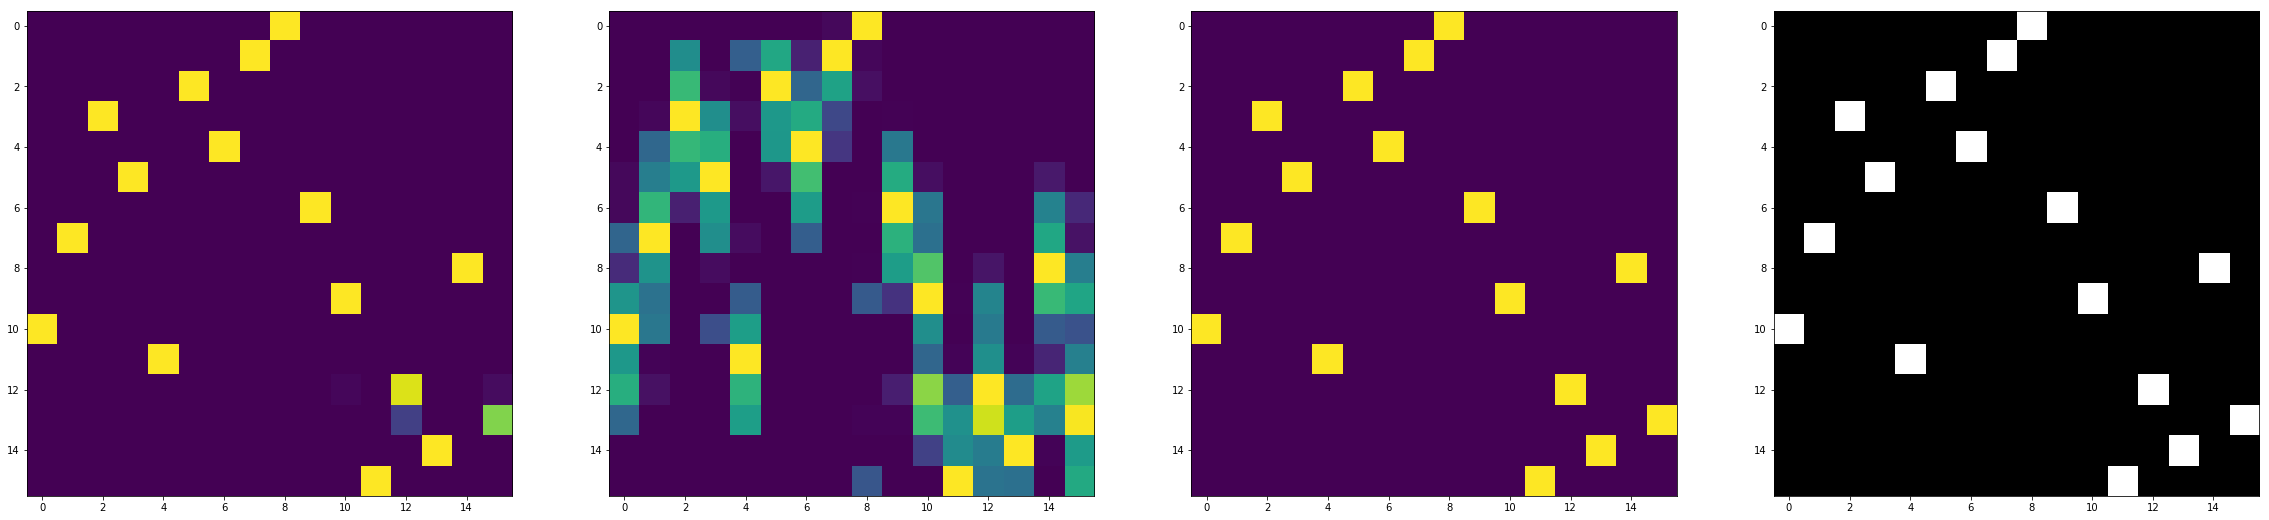

('INPUT:', [568.0, 449.0, 128.0, 402.0, 893.0, 78.0, 338.0, 60.0, 43.0, 427.0, 561.0, 990.0, 948.0, 983.0, 477.0, 948.0])
('PREDICT:', [43.0, 60.00239562988281, 78.02625274658203, 128.02749633789062, 337.9073486328125, 401.9371337890625, 427.0050964355469, 448.99664306640625, 477.1619873046875, 560.9872436523438, 568.0136108398438, 892.9933471679688, 940.5081787109375, 947.724365234375, 982.9989013671875, 989.9947509765625])
('P_HARD:', [43.0, 60.0, 78.0, 128.0, 338.0, 402.0, 427.0, 449.0, 477.0, 561.0, 568.0, 893.0, 948.0, 948.0, 983.0, 990.0])
('TRUE   :', [43.0, 60.0, 78.0, 128.0, 338.0, 402.0, 427.0, 449.0, 477.0, 561.0, 568.0, 893.0, 948.0, 948.0, 983.0, 990.0])
0.867571017236
[ 0.5917  0.1325 -1.1061 -0.0488  1.8458 -1.299  -0.2958 -1.3685 -1.4341
  0.0477  0.5647  2.2201  2.058   2.1931  0.2406  2.058 ]
('METRIC:', array([0]))
('NORM:  ', array([ 8,  7,  5,  2,  6,  3,  9,  1, 14, 10,  0,  4, 12, 15, 13, 11]))


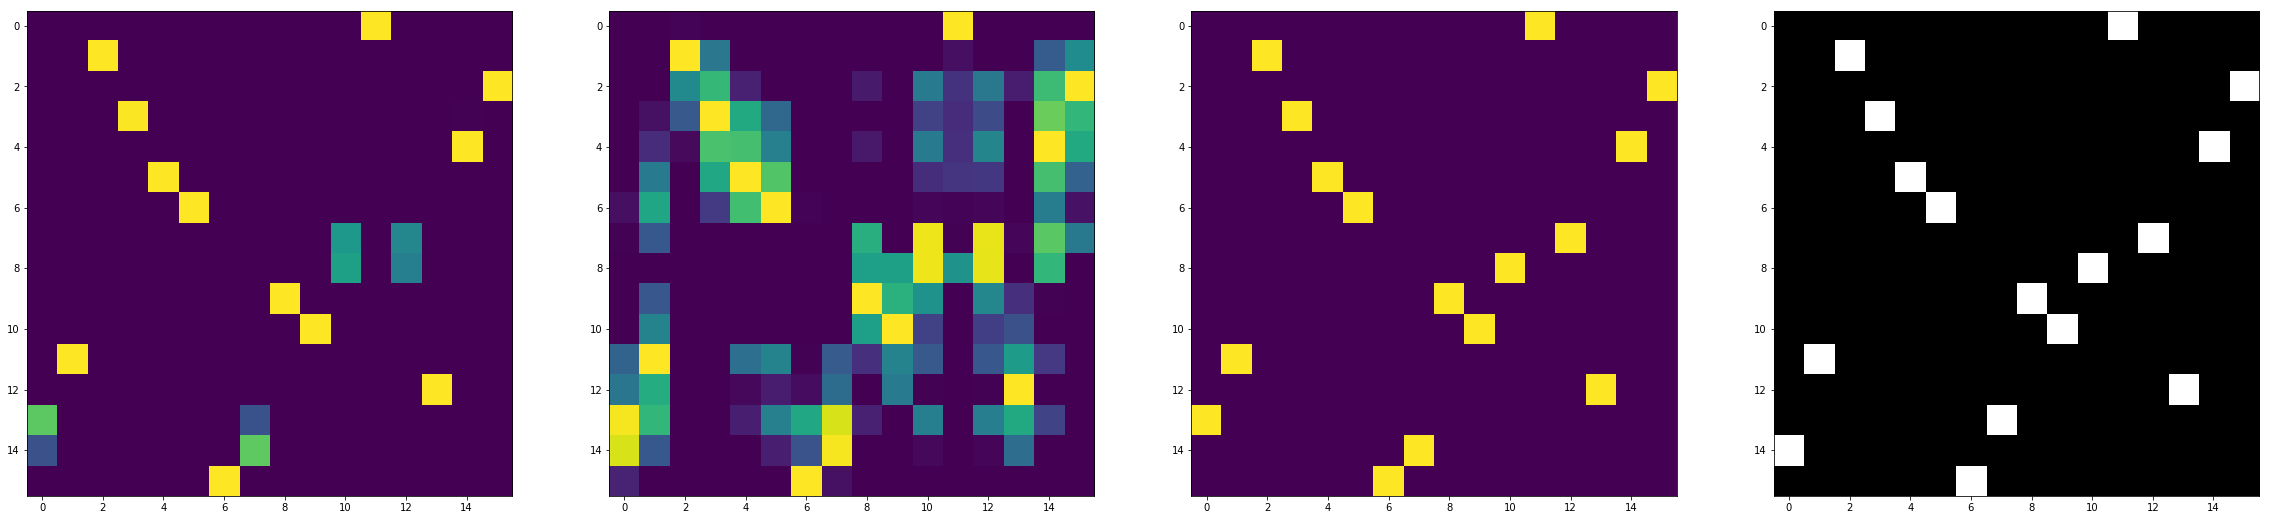

('INPUT:', [810.0, 612.0, 186.0, 233.0, 256.0, 309.0, 996.0, 803.0, 463.0, 480.0, 323.0, 17.0, 315.0, 711.0, 241.0, 220.0])
('PREDICT:', [17.0, 186.00030517578125, 220.02154541015625, 233.0404052734375, 241.0030517578125, 256.08367919921875, 308.9710693359375, 319.0992126464844, 319.53192138671875, 463.0018005371094, 479.99969482421875, 612.0016479492188, 710.9845581054688, 808.1564331054688, 804.7443237304688, 996.0])
('P_HARD:', [17.0, 186.0, 220.0, 233.0, 241.0, 256.0, 309.0, 315.0, 323.0, 463.0, 480.0, 612.0, 711.0, 810.0, 803.0, 996.0])
('TRUE   :', [17.0, 186.0, 220.0, 233.0, 241.0, 256.0, 309.0, 315.0, 323.0, 463.0, 480.0, 612.0, 711.0, 803.0, 810.0, 996.0])
0.460252689934
[ 2.1161  1.2077 -0.7467 -0.531  -0.4255 -0.1824  2.9695  2.084   0.5242
  0.6022 -0.1181 -1.522  -0.1548  1.6619 -0.4943 -0.5907]
('METRIC:', array([0]))
('NORM:  ', array([11,  2, 15,  3, 14,  4,  5, 12, 10,  8,  9,  1, 13,  7,  0,  6]))


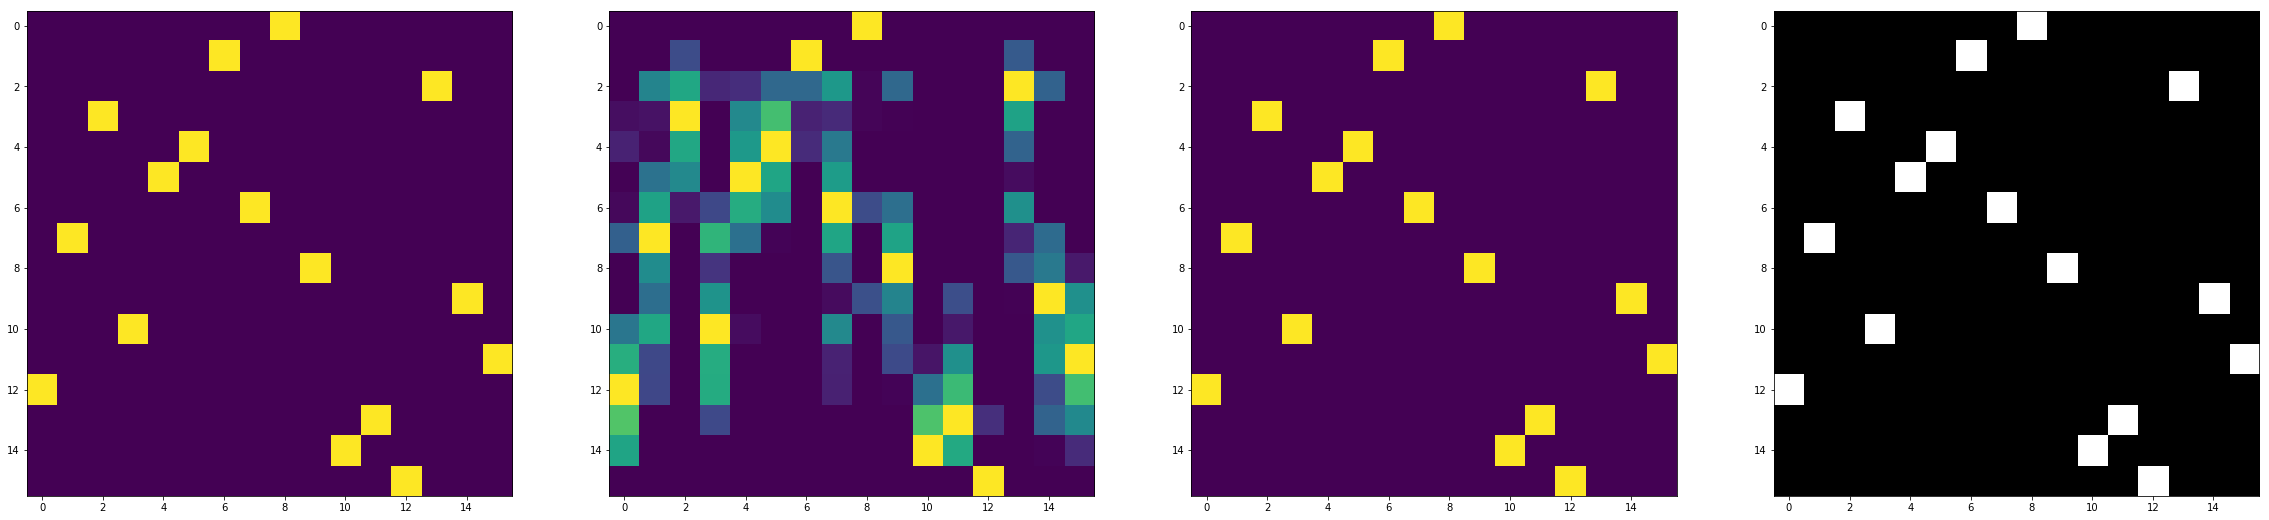

('INPUT:', [801.0, 460.0, 278.0, 606.0, 320.0, 299.0, 185.0, 410.0, 2.0, 492.0, 876.0, 829.0, 923.0, 246.0, 567.0, 699.0])
('PREDICT:', [2.0, 185.0, 246.00718688964844, 278.02044677734375, 298.99853515625, 320.0011291503906, 409.9869079589844, 460.05084228515625, 491.9998779296875, 567.0015258789062, 605.9926147460938, 699.0029907226562, 800.8972778320312, 829.0211791992188, 875.9893188476562, 923.0])
('P_HARD:', [2.0, 185.0, 246.0, 278.0, 299.0, 320.0, 410.0, 460.0, 492.0, 567.0, 606.0, 699.0, 801.0, 829.0, 876.0, 923.0])
('TRUE   :', [2.0, 185.0, 246.0, 278.0, 299.0, 320.0, 410.0, 460.0, 492.0, 567.0, 606.0, 699.0, 801.0, 829.0, 876.0, 923.0])
0.205682484191
[ 1.6068  0.2416 -0.487   0.8261 -0.3189 -0.403  -0.8594  0.0414 -1.592
  0.3697  1.9071  1.7189  2.0952 -0.6151  0.67    1.1984]
('METRIC:', array([0]))
('NORM:  ', array([ 8,  6, 13,  2,  5,  4,  7,  1,  9, 14,  3, 15,  0, 11, 10, 12]))


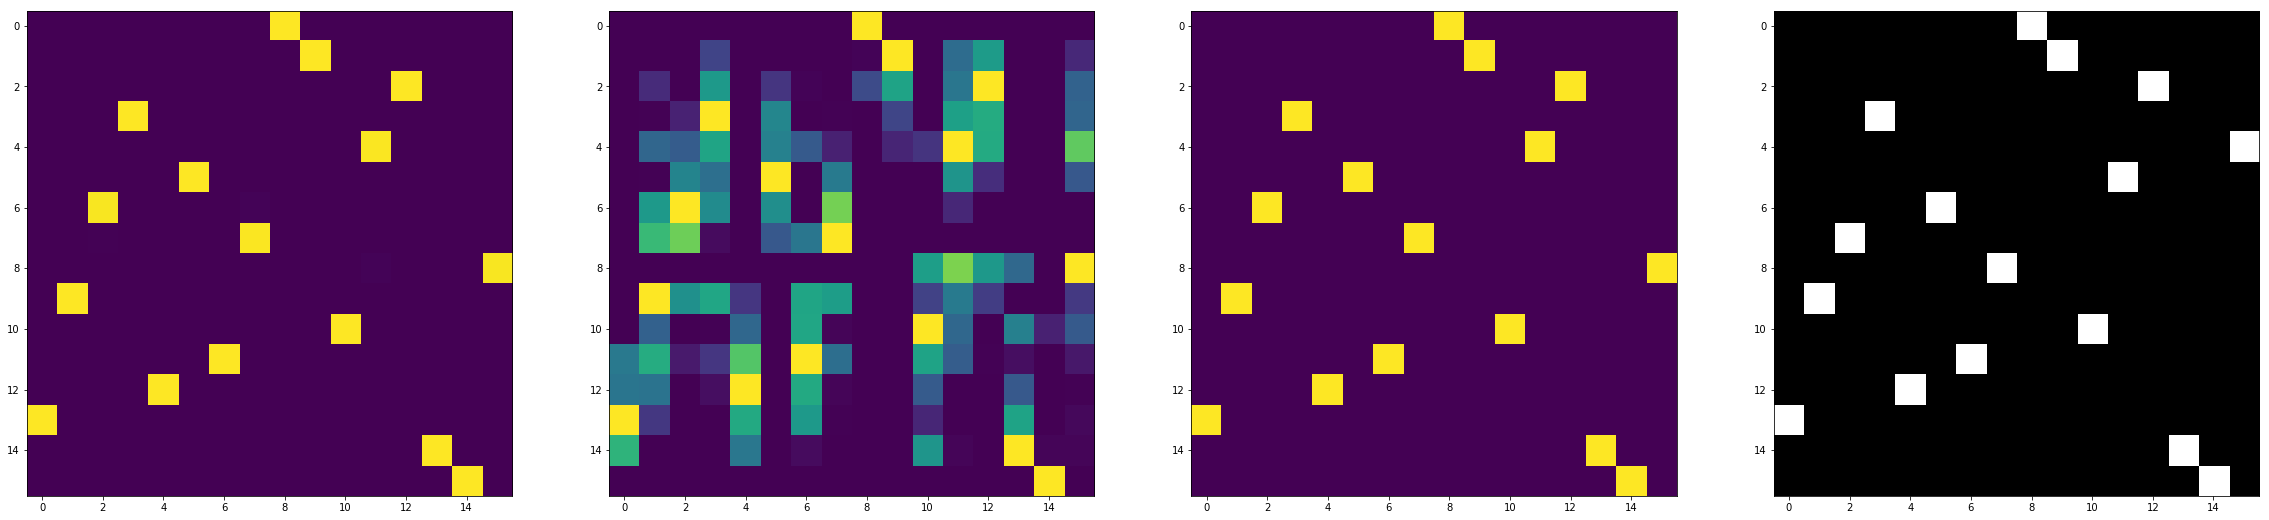

('INPUT:', [932.0, 759.0, 706.0, 270.0, 851.0, 650.0, 839.0, 727.0, 104.0, 198.0, 798.0, 322.0, 241.0, 948.0, 980.0, 315.0])
('PREDICT:', [104.0, 198.0013885498047, 240.998046875, 269.999755859375, 321.9610900878906, 649.9951171875, 706.169677734375, 726.8853149414062, 315.08929443359375, 758.964111328125, 798.0036010742188, 839.0111083984375, 850.9987182617188, 931.9890747070312, 947.9923095703125, 980.0])
('P_HARD:', [104.0, 198.0, 241.0, 270.0, 322.0, 650.0, 706.0, 727.0, 315.0, 759.0, 798.0, 839.0, 851.0, 932.0, 948.0, 980.0])
('TRUE   :', [104.0, 198.0, 241.0, 270.0, 315.0, 322.0, 650.0, 706.0, 727.0, 759.0, 798.0, 839.0, 851.0, 932.0, 948.0, 980.0])
0.728572594775
[ 1.4938  0.9195  0.7436 -0.7037  1.2249  0.5577  1.1851  0.8133 -1.2548
 -0.9427  1.049  -0.5311 -0.8     1.5469  1.6531 -0.5544]
('METRIC:', array([0]))
('NORM:  ', array([ 8,  9, 12,  3, 15, 11,  5,  2,  7,  1, 10,  6,  4,  0, 13, 14]))


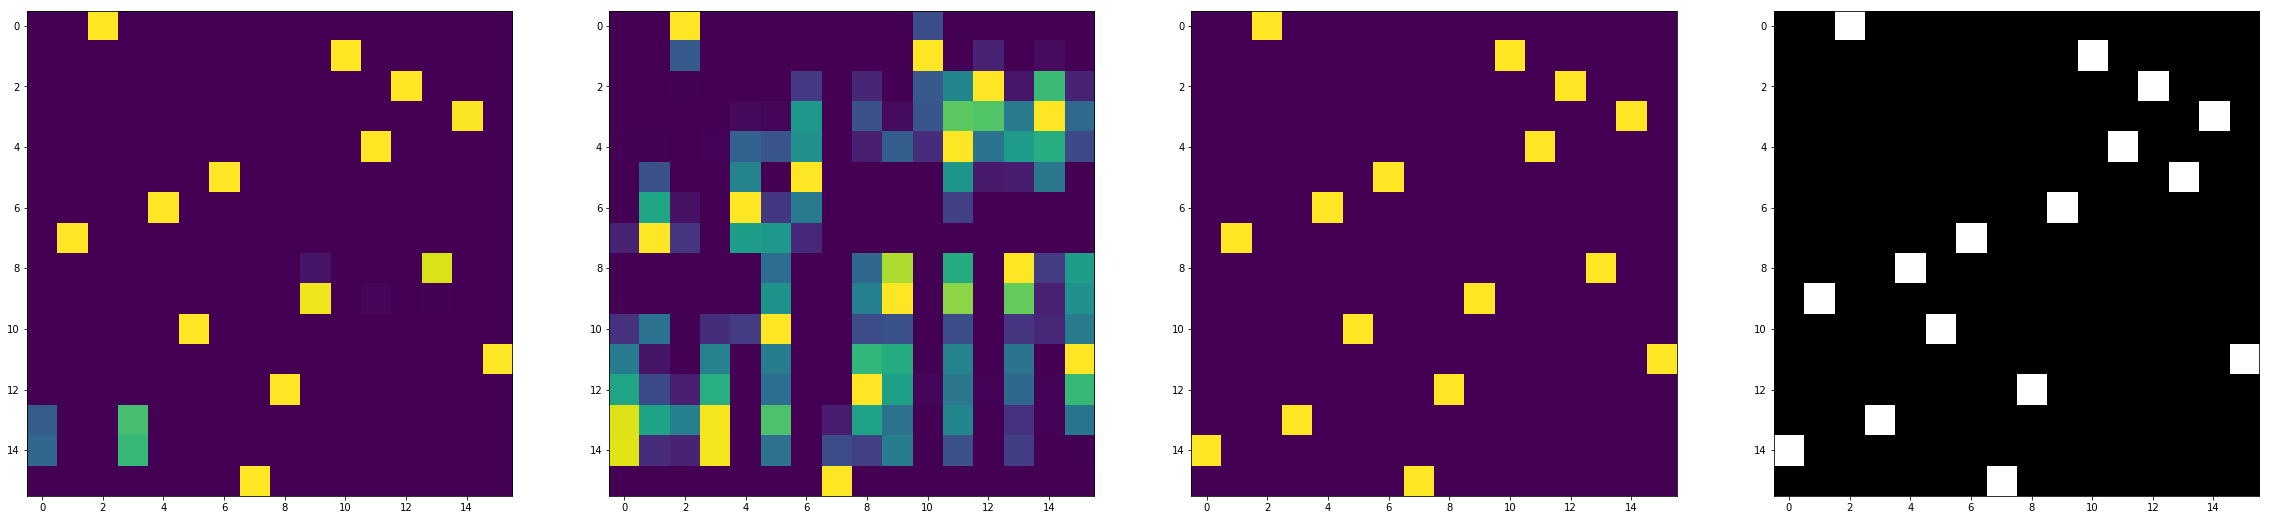

('INPUT:', [861.0, 566.0, 4.0, 853.0, 524.0, 602.0, 351.0, 933.0, 840.0, 232.0, 36.0, 180.0, 108.0, 213.0, 153.0, 822.0])
('PREDICT:', [4.000000953674316, 35.999996185302734, 108.03060913085938, 152.9943084716797, 179.99835205078125, 350.9974060058594, 524.0028686523438, 565.9990844726562, 214.10610961914062, 231.00013732910156, 602.0003051757812, 821.9093017578125, 839.96484375, 854.9329223632812, 855.6443481445312, 933.0])
('P_HARD:', [4.0, 36.0, 108.0, 153.0, 180.0, 351.0, 524.0, 566.0, 213.0, 232.0, 602.0, 822.0, 840.0, 853.0, 861.0, 933.0])
('TRUE   :', [4.0, 36.0, 108.0, 153.0, 180.0, 213.0, 232.0, 351.0, 524.0, 566.0, 602.0, 822.0, 840.0, 853.0, 861.0, 933.0])
0.831682853269
[ 2.1857  0.8886 -1.5824  2.1505  0.7039  1.0469 -0.0567  2.5022  2.0933
 -0.5799 -1.4417 -0.8086 -1.1251 -0.6635 -0.9273  2.0142]
('METRIC:', array([0]))
('NORM:  ', array([ 2, 10, 12, 14, 11, 13,  9,  6,  4,  1,  5, 15,  8,  3,  0,  7]))


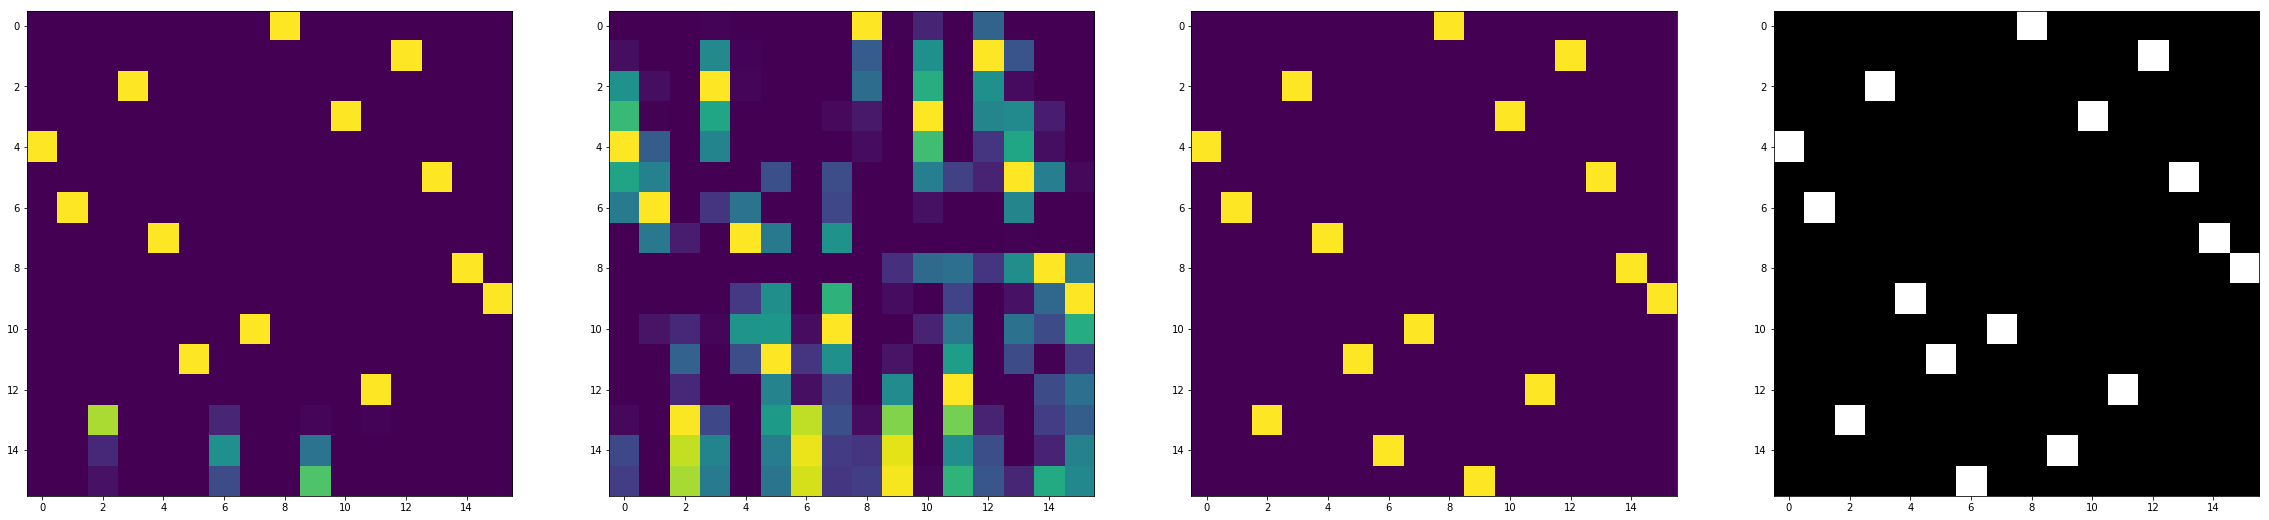

('INPUT:', [223.0, 292.0, 983.0, 186.0, 562.0, 701.0, 994.0, 638.0, 25.0, 984.0, 206.0, 948.0, 79.0, 279.0, 311.0, 544.0])
('PREDICT:', [25.000009536743164, 79.00193786621094, 186.00271606445312, 206.00732421875, 222.99021911621094, 278.9962463378906, 292.0, 562.0008544921875, 311.00018310546875, 544.030029296875, 637.9860229492188, 701.0093994140625, 947.9993286132812, 983.891845703125, 988.8917846679688, 986.1331176757812])
('P_HARD:', [25.0, 79.0, 186.0, 206.0, 223.0, 279.0, 292.0, 562.0, 311.0, 544.0, 638.0, 701.0, 948.0, 983.0, 994.0, 984.0])
('TRUE   :', [25.0, 79.0, 186.0, 206.0, 223.0, 279.0, 292.0, 311.0, 544.0, 562.0, 638.0, 701.0, 948.0, 983.0, 984.0, 994.0])
0.392155296693
[-0.703  -0.4254  2.3542 -0.8518  0.6607  1.2199  2.3985  0.9664 -1.4994
  2.3583 -0.7713  2.2135 -1.2822 -0.4777 -0.349   0.5883]
('METRIC:', array([0]))
('NORM:  ', array([ 8, 12,  3, 10,  0, 13,  1, 14, 15,  4,  7,  5, 11,  2,  9,  6]))


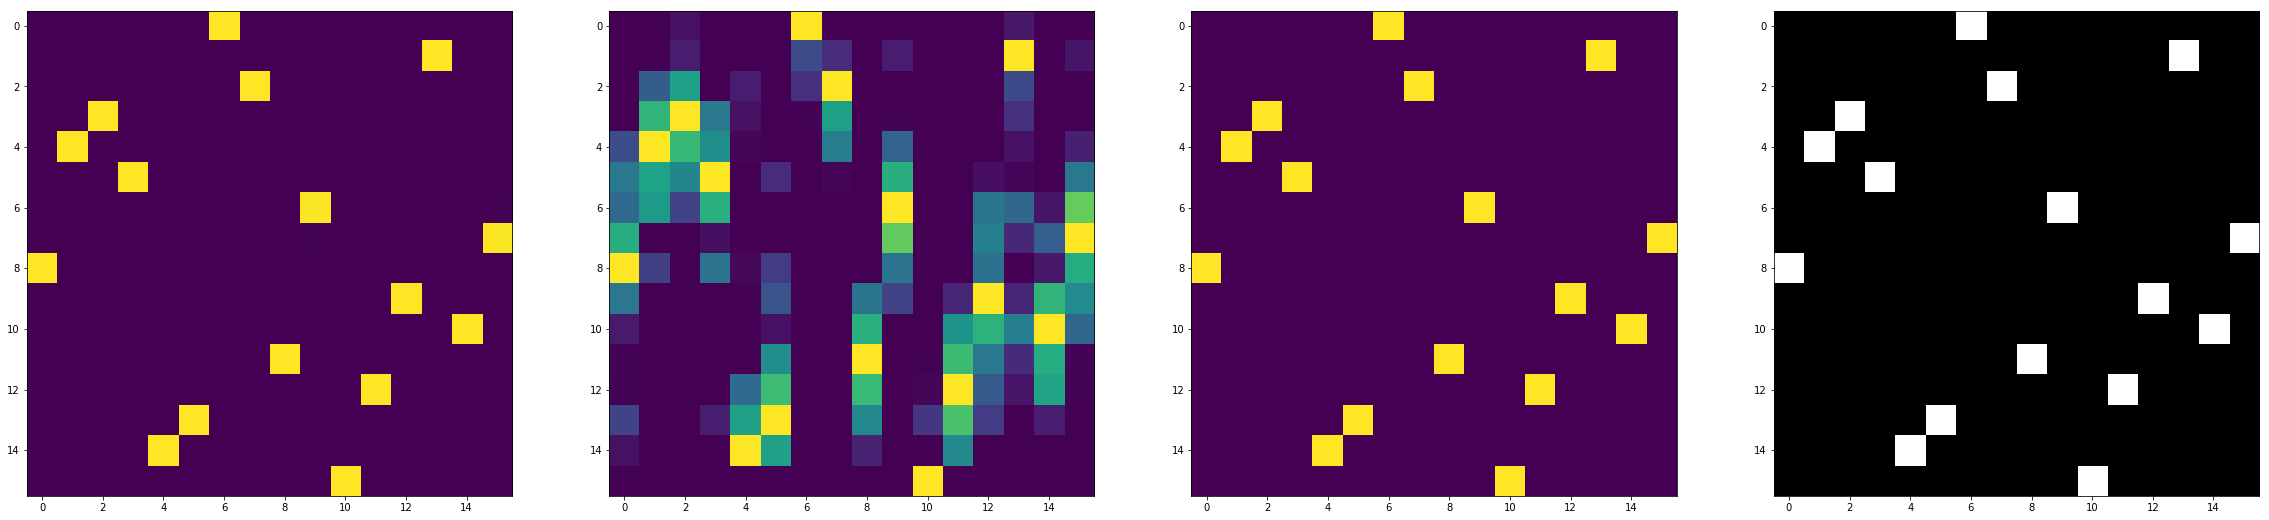

('INPUT:', [658.0, 229.0, 141.0, 531.0, 918.0, 878.0, 47.0, 128.0, 838.0, 550.0, 993.0, 867.0, 703.0, 90.0, 729.0, 589.0])
('PREDICT:', [47.0, 90.0, 128.00070190429688, 141.02987670898438, 228.95849609375, 530.9830322265625, 550.1490478515625, 588.857177734375, 657.9888305664062, 703.00830078125, 729.017578125, 838.0046997070312, 866.9822998046875, 877.987548828125, 917.9976806640625, 993.0])
('P_HARD:', [47.0, 90.0, 128.0, 141.0, 229.0, 531.0, 550.0, 589.0, 658.0, 703.0, 729.0, 838.0, 867.0, 878.0, 918.0, 993.0])
('TRUE   :', [47.0, 90.0, 128.0, 141.0, 229.0, 531.0, 550.0, 589.0, 658.0, 703.0, 729.0, 838.0, 867.0, 878.0, 918.0, 993.0])
0.77987503428
[ 0.7688 -0.7756 -1.0924  0.3116  1.7048  1.5608 -1.4308 -1.1392  1.4168
  0.38    1.9748  1.5212  0.9308 -1.276   1.0244  0.5204]
('METRIC:', array([0]))
('NORM:  ', array([ 6, 13,  7,  2,  1,  3,  9, 15,  0, 12, 14,  8, 11,  5,  4, 10]))


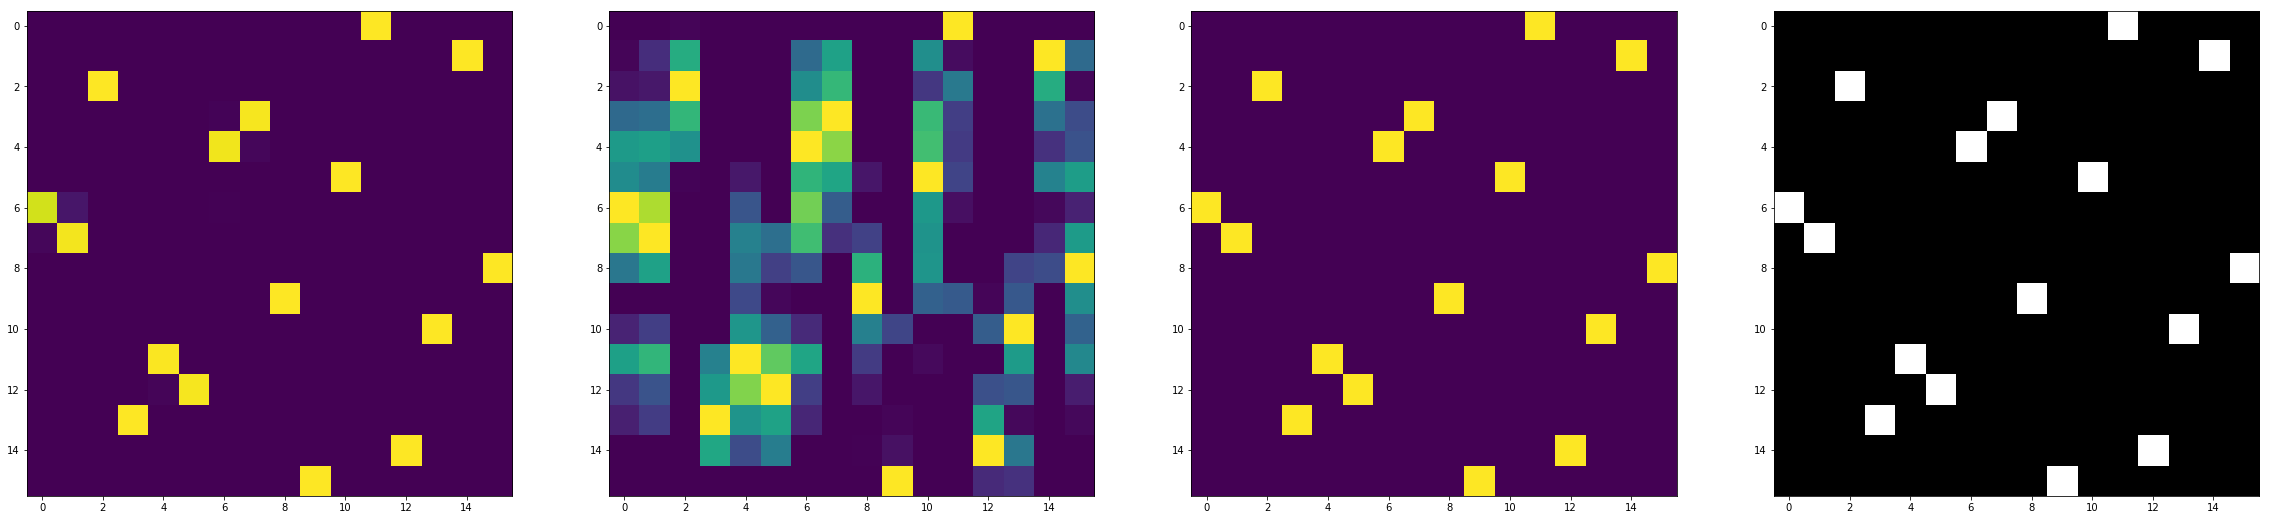

('INPUT:', [337.0, 349.0, 247.0, 845.0, 765.0, 785.0, 293.0, 279.0, 510.0, 972.0, 316.0, 38.0, 891.0, 675.0, 170.0, 379.0])
('PREDICT:', [38.0, 170.01939392089844, 247.00242614746094, 279.1603698730469, 292.7625427246094, 315.9909362792969, 337.388671875, 348.7471923828125, 379.0335998535156, 509.9988708496094, 675.0012817382812, 764.8475341796875, 784.7529296875, 844.998291015625, 890.9955444335938, 972.0])
('P_HARD:', [38.0, 170.0, 247.0, 279.0, 293.0, 316.0, 337.0, 349.0, 379.0, 510.0, 675.0, 765.0, 785.0, 845.0, 891.0, 972.0])
('TRUE   :', [38.0, 170.0, 247.0, 279.0, 293.0, 316.0, 337.0, 349.0, 379.0, 510.0, 675.0, 765.0, 785.0, 845.0, 891.0, 972.0])
0.975458121981
[-0.2264 -0.1775 -0.5932  1.8441  1.5181  1.5996 -0.4058 -0.4628  0.4787
  2.3618 -0.312  -1.4451  2.0316  1.1512 -0.9071 -0.0552]
('METRIC:', array([0]))
('NORM:  ', array([11, 14,  2,  7,  6, 10,  0,  1, 15,  8, 13,  4,  5,  3, 12,  9]))


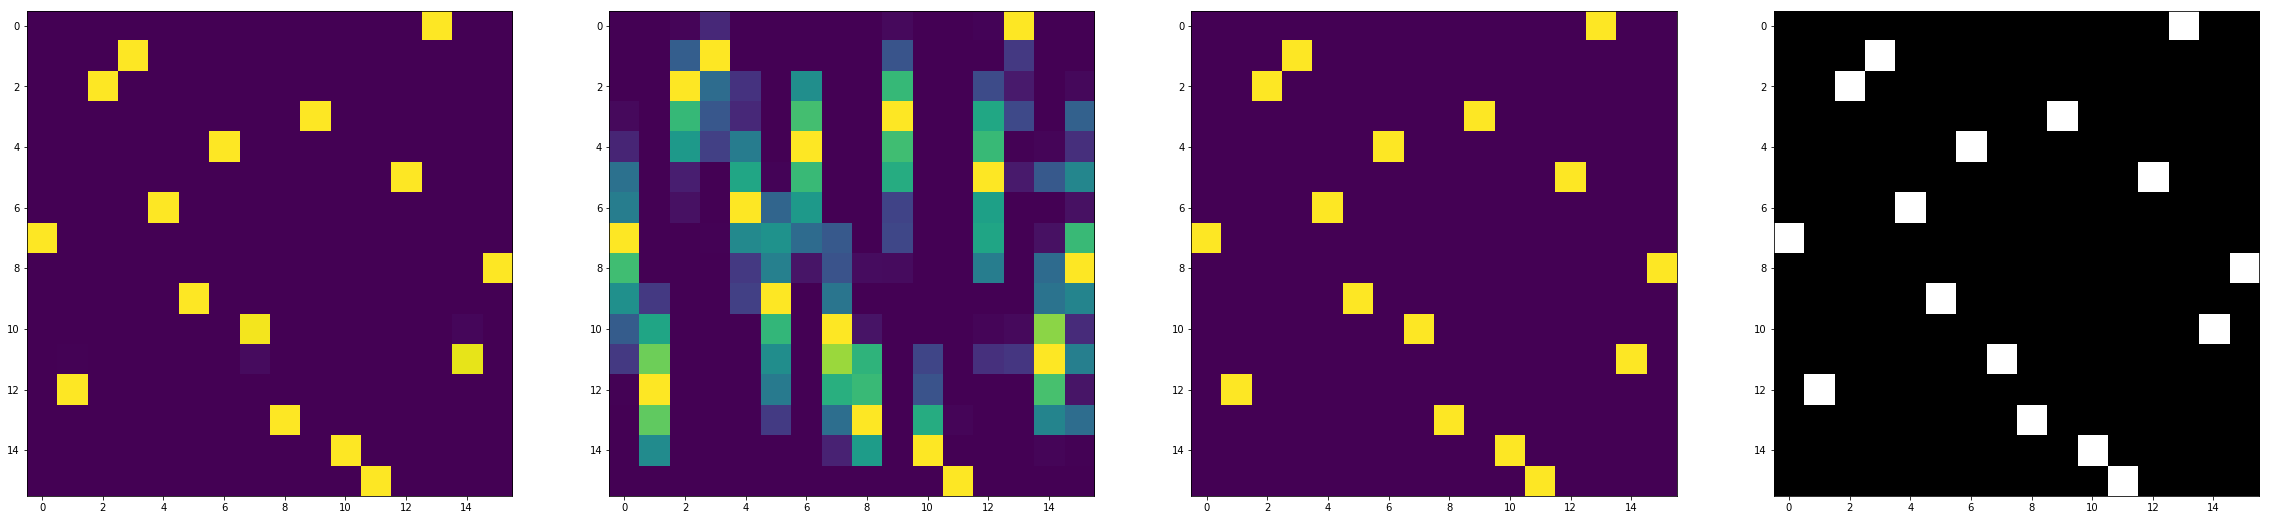

('INPUT:', [296.0, 836.0, 66.0, 38.0, 241.0, 547.0, 127.0, 805.0, 842.0, 123.0, 874.0, 912.0, 170.0, 18.0, 802.0, 301.0])
('PREDICT:', [18.0, 38.000003814697266, 66.0280990600586, 122.98082733154297, 127.01939392089844, 169.9737091064453, 240.9939422607422, 295.99658203125, 300.9962158203125, 546.9970092773438, 804.8428955078125, 802.3218383789062, 835.955078125, 841.9832763671875, 873.9987182617188, 912.0])
('P_HARD:', [18.0, 38.0, 66.0, 123.0, 127.0, 170.0, 241.0, 296.0, 301.0, 547.0, 805.0, 802.0, 836.0, 842.0, 874.0, 912.0])
('TRUE   :', [18.0, 38.0, 66.0, 123.0, 127.0, 170.0, 241.0, 296.0, 301.0, 547.0, 802.0, 805.0, 836.0, 842.0, 874.0, 912.0])
0.865487295141
[-0.2465  2.2228 -1.2982 -1.4262 -0.498   0.9013 -1.0193  2.0811  2.2502
 -1.0376  2.3966  2.5703 -0.8226 -1.5177  2.0673 -0.2236]
('METRIC:', array([0]))
('NORM:  ', array([13,  3,  2,  9,  6, 12,  4,  0, 15,  5, 14,  7,  1,  8, 10, 11]))


In [151]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

import matplotlib.pyplot as plt
#print(model.summary())

nb_show = 10

np.set_printoptions(suppress=True,threshold=500000)
out = model.predict(val[:nb_show])
p,u = out[0],out[1]


if(len(out) > 2):
    metric = out[2]
else:
    metric = np.random.random(nb_show)
#p,u = model.predict(val)
#met = [0]*10
#print("VAL_MSE:", float(K.eval(K.mean(K.pow(p - val_target, 2)))))

for x,a,b,indx,c,met in zip(val[:nb_show]*1000,p[:nb_show]*1000.0,val_target[:nb_show]*1000.0,val_sort_indicies[:nb_show],u[:nb_show],metric[:nb_show]):
#for x,a,indx,c in zip(val[:10]*1000,val_target[:10]*1000.0,val_sort_indicies[:10],u[:10]):
    from pylab import rcParams
    rcParams['figure.figsize'] = 40, 40
    actual = indx_to_transform(indx)
    fig = plt.figure(1)
    ax1 = fig.add_subplot(1,4,1)
    im = ax1.imshow(c)
    #fig.colorbar(im,ax=ax1)
    
    fig = plt.figure(1)
    ax2 = fig.add_subplot(1,4,2)
    im = ax2.imshow(np.log(c+1e-10))
    
    
    
    x_flat = flatten(x[:,0].tolist())
    a_flat = flatten(a[:,0].tolist())
    b_flat = flatten(b[:,0].tolist())

    #u = to_transform(x,b)
    
    c_m = np.max(c,axis=0)
    #c_fixed = (c/c_m) * (c-c_m >= 0.0)
    c_fixed = 2.0*(c/c_m) * sigmoid(1e10*(c-c_m))
    
    ax3 = fig.add_subplot(1,4,3)
    im = ax3.imshow(c_fixed)
    #fig.colorbar(im,ax=ax3)
    #plt.show()
    
    
    
    
    ax4 = fig.add_subplot(1,4,4)
    ax4.imshow(actual,cmap='gray')
    #plt.colorbar()
    plt.show()
    
    print("INPUT:",x_flat)
   
    
    
    print("PREDICT:",a_flat)
    print("P_HARD:",np.dot(c_fixed,x[:,:1]).ravel().tolist())
    print("TRUE   :",b_flat)
    
    print(met)
    print(2.0*(np.linalg.norm(x,axis=-1)/np.average(np.linalg.norm(x,axis=-1))-.8))
    print("METRIC:",np.argsort(met))
    print("NORM:  ", np.argsort(np.linalg.norm(x,axis=-1)))
#print([np.concatenate(list(x), axis=-1) for ])
#print(target)

In [ ]:
x = Input(shape=(SEQ_LEN, 1), name="input")
o = Flatten()(x)
o = SortN(SEQ_LEN)(o) 
o = Reshape((-1,1))(o)
model = Model(input=x, output=o, name='test')
model.compile(optimizer='adam',loss='mse')
model.fit(inp, target, nb_epoch=1,batch_size=100)


In [ ]:
print(sweep)
print(mses)
print(runs)

#for m,sp in zip(models,sweep):
#    print(sp)
p,u = model.predict(val[9:19])
for c in u:
    plt.imshow(c)
    plt.colorbar()
    plt.show()
#d = {"one":1, "two":2}

#50 floats btw 0-1 
    #w/o tanh ptr_net
    #Does not converge
    #Tanh ptr_net
    #0.0006992769549385588
    
    #w/o tanh custom
    #0.0027380140176726468
    #Tanh custom
    #0.008146504258126774
    
    #ptr_net 5 epoch:
    #[0.0, 0.001, 0.01, 0.1, 1.0, 10.0]
    #[0.0005530958605927241, 0.0008726149090503212, 0.000940361804486735, 0.0006479378772081163, 0.002113587790538396, 0.00886053613683831]
    
    #ptr_net 15 epoch:
    #[0.0, 1e-05, 0.0001, 0.001, 0.01, 0.025, 0.1, 1.0]
    #[0.0005856020492227538, 0.000435507757379088, 0.0005835100906981886, 0.0007385180880908348, 0.00038265960976375526, 0.0004894350985301985, 0.00042241677262379437, 0.000939572834186924]


#print("VAL_LOSS:", model.evaluate(val,val_target,batch_size=1))
#print("VAL_LOSS:", model.evaluate(val,val_target,batch_size=10))
#print("VAL_LOSS:", model.evaluate(val,val_target,batch_size=100))

In [91]:
from keras.engine.topology import Layer,initializations,Merge
def null_cost(y_true, y_pred):
    # output itself is cost and must be minimized
    return K.sum(y_pred)*0 + K.sum(y_true)*0
def buildModel(sparsity_coeff=0.0):
    x = Input(shape=(SEQ_LEN, 4), name="input")
    e = GRU(128,return_sequences=True)(x)
    s = Slice("[-1,:]")(e)
    # s = Slice('[-1,:]')(e)
    # s = theano.printing.Print("s")(s)
    r = RepeatVector(SEQ_LEN)(s)
    m = Merge(mode='concat',concat_axis=2)([r,x])
    d = GRU(128,return_sequences=True)(m)
    p,u = Ptr_Layer(20,sparsity_coeff=sparsity_coeff,return_U=True,
                    implementation='custom',seq_len=SEQ_LEN)([x,e,d])

    model = Model(input=x, output=[p,u], name='test')
    model.compile(optimizer='adam',loss=['mse',null_cost],loss_weights=[1., 0.0])
    return model


In [35]:
'''Epoch 1/1
50000/50000 [==============================] - 780s - loss: 0.0016   
('VAL_MSE:', 8.391598572468554e-05)
Epoch 1/1
50000/50000 [==============================] - 786s - loss: 1.3540e-04   
('VAL_MSE:', 0.00015946542762654568)
Epoch 1/1
50000/50000 [==============================] - 781s - loss: 1.3643e-04   
('VAL_MSE:', 7.359234000334871e-05)
Epoch 1/1
50000/50000 [==============================] - 790s - loss: 1.1043e-04   
('VAL_MSE:', 0.00037620730748726995)
Epoch 1/1
50000/50000 [==============================] - 778s - loss: 9.5742e-05   
('VAL_MSE:', 0.0004603614554866676)
Epoch 1/1
50000/50000 [==============================] - 793s - loss: 8.6783e-05   
('VAL_MSE:', 0.0006976922938582105)
Epoch 1/1
50000/50000 [==============================] - 766s - loss: 8.3102e-05   
('VAL_MSE:', 0.0010426845653969696)
Epoch 1/1
50000/50000 [==============================] - 781s - loss: 8.1857e-05   
('VAL_MSE:', 0.0010114745970606362)
Epoch 1/1
50000/50000 [==============================] - 776s - loss: 1.7436e-04   
('VAL_MSE:', 0.0001110254697785855)
Epoch 1/1
32700/50000 [==================>...........] - ETA: 260s - loss: 1.2367e-04
'''

"Epoch 1/1\n50000/50000 [==============================] - 780s - loss: 0.0016   \n('VAL_MSE:', 8.391598572468554e-05)\nEpoch 1/1\n50000/50000 [==============================] - 786s - loss: 1.3540e-04   \n('VAL_MSE:', 0.00015946542762654568)\nEpoch 1/1\n50000/50000 [==============================] - 781s - loss: 1.3643e-04   \n('VAL_MSE:', 7.359234000334871e-05)\nEpoch 1/1\n50000/50000 [==============================] - 790s - loss: 1.1043e-04   \n('VAL_MSE:', 0.00037620730748726995)\nEpoch 1/1\n50000/50000 [==============================] - 778s - loss: 9.5742e-05   \n('VAL_MSE:', 0.0004603614554866676)\nEpoch 1/1\n50000/50000 [==============================] - 793s - loss: 8.6783e-05   \n('VAL_MSE:', 0.0006976922938582105)\nEpoch 1/1\n50000/50000 [==============================] - 766s - loss: 8.3102e-05   \n('VAL_MSE:', 0.0010426845653969696)\nEpoch 1/1\n50000/50000 [==============================] - 781s - loss: 8.1857e-05   \n('VAL_MSE:', 0.0010114745970606362)\nEpoch 1/1\n50000/

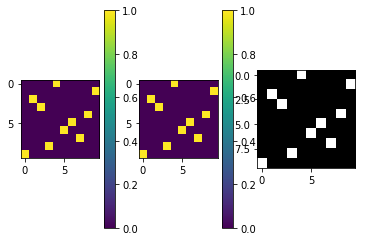

('INPUT:', [980.0, 271.0, 362.0, 940.0, 96.0, 754.0, 619.0, 785.0, 957.0, 188.0])
('PREDICT:', [96.0, 188.18785095214844, 271.2080383300781, 363.0690002441406, 956.4525146484375, 619.072021484375, 753.8741455078125, 784.9395141601562, 940.0, 980.0])
('TRUE   :', [96.0, 188.0, 271.0, 362.0, 957.0, 619.0, 754.0, 785.0, 940.0, 980.0])
('METRIC:', array([4, 9, 1, 2, 8, 6, 5, 7, 3, 0]))
('NORM:', array([4, 9, 1, 2, 8, 6, 5, 7, 3, 0]))


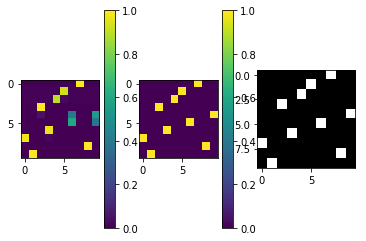

('INPUT:', [408.0, 783.0, 62.0, 34.0, 496.0, 852.0, 608.0, 299.0, 601.0, 734.0])
('PREDICT:', [299.003173828125, 822.352294921875, 499.2033996582031, 63.8026237487793, 646.7023315429688, 655.57666015625, 50.05015182495117, 401.18255615234375, 600.9888916015625, 783.0])
('TRUE   :', [299.0, 852.0, 496.0, 62.0, 734.0, 608.0, 34.0, 408.0, 601.0, 783.0])
('METRIC:', array([7, 5, 4, 2, 6, 9, 3, 0, 8, 1]))
('NORM:', array([7, 5, 4, 2, 9, 6, 3, 0, 8, 1]))


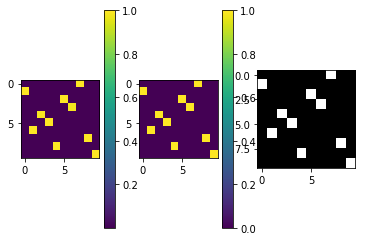

('INPUT:', [810.0, 935.0, 208.0, 358.0, 195.0, 364.0, 402.0, 360.0, 733.0, 474.0])
('PREDICT:', [360.0, 809.953369140625, 364.2901916503906, 403.6209411621094, 210.5982208251953, 357.8757629394531, 934.9104614257812, 732.8056640625, 195.8802032470703, 474.00006103515625])
('TRUE   :', [360.0, 810.0, 364.0, 402.0, 208.0, 358.0, 935.0, 733.0, 195.0, 474.0])
('METRIC:', array([7, 0, 5, 6, 2, 3, 1, 8, 4, 9]))
('NORM:', array([7, 0, 5, 6, 2, 3, 1, 8, 4, 9]))


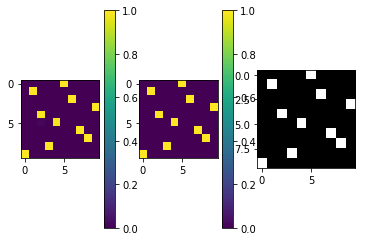

('INPUT:', [149.0, 88.0, 507.0, 598.0, 285.0, 27.0, 361.0, 135.0, 892.0, 149.0])
('PREDICT:', [27.0, 88.66006469726562, 360.927001953125, 149.48941040039062, 504.3604431152344, 288.0234680175781, 135.2672119140625, 891.4509887695312, 597.98583984375, 149.0])
('TRUE   :', [27.0, 88.0, 361.0, 149.0, 507.0, 285.0, 135.0, 892.0, 598.0, 149.0])
('METRIC:', array([5, 1, 6, 9, 2, 4, 7, 8, 3, 0]))
('NORM:', array([5, 1, 6, 9, 2, 4, 7, 8, 3, 0]))


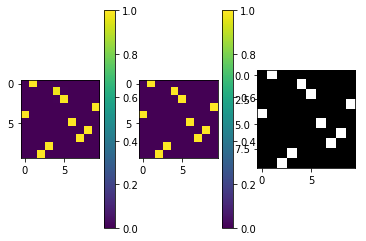

('INPUT:', [682.0, 915.0, 871.0, 448.0, 194.0, 763.0, 760.0, 831.0, 67.0, 240.0])
('PREDICT:', [915.0003051757812, 205.2794952392578, 759.6760864257812, 242.0104217529297, 681.5565795898438, 759.5029907226562, 68.6391830444336, 830.188232421875, 448.0091247558594, 871.0])
('TRUE   :', [915.0, 194.0, 763.0, 240.0, 682.0, 760.0, 67.0, 831.0, 448.0, 871.0])
('METRIC:', array([1, 4, 5, 9, 0, 6, 8, 7, 3, 2]))
('NORM:', array([1, 4, 5, 9, 0, 6, 8, 7, 3, 2]))


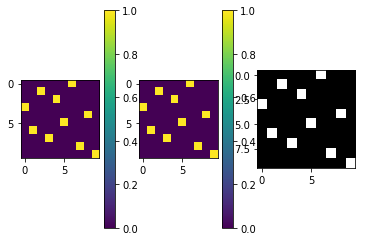

('INPUT:', [284.0, 537.0, 258.0, 564.0, 643.0, 996.0, 607.0, 510.0, 386.0, 804.0])
('PREDICT:', [606.9893798828125, 258.02783203125, 642.8731689453125, 284.1686096191406, 386.4659118652344, 995.5762329101562, 537.1100463867188, 563.979736328125, 510.24676513671875, 804.0])
('TRUE   :', [607.0, 258.0, 643.0, 284.0, 386.0, 996.0, 537.0, 564.0, 510.0, 804.0])
('METRIC:', array([6, 2, 4, 0, 8, 5, 1, 3, 7, 9]))
('NORM:', array([6, 2, 4, 0, 8, 5, 1, 3, 7, 9]))


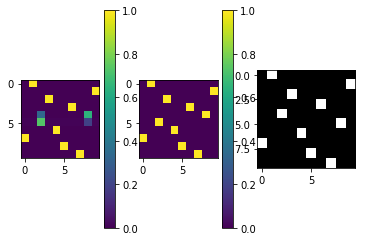

('INPUT:', [14.0, 436.0, 241.0, 570.0, 618.0, 641.0, 895.0, 609.0, 125.0, 13.0])
('PREDICT:', [436.0, 13.10180377960205, 569.1702270507812, 893.9393920898438, 172.1217803955078, 236.47329711914062, 617.5115356445312, 14.323737144470215, 640.993408203125, 609.0])
('TRUE   :', [436.0, 13.0, 570.0, 895.0, 241.0, 125.0, 618.0, 14.0, 641.0, 609.0])
('METRIC:', array([1, 9, 3, 6, 8, 2, 4, 0, 5, 7]))
('NORM:', array([1, 9, 3, 6, 2, 8, 4, 0, 5, 7]))


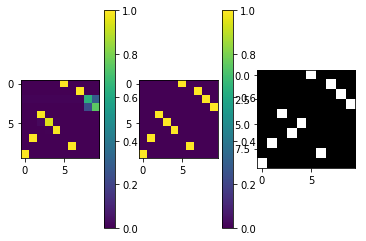

('INPUT:', [940.0, 595.0, 222.0, 109.0, 464.0, 66.0, 677.0, 180.0, 374.0, 716.0])
('PREDICT:', [66.0, 180.19456481933594, 475.9359436035156, 630.0132446289062, 224.32723999023438, 121.94139862060547, 462.5343933105469, 594.977783203125, 676.7172241210938, 940.0])
('TRUE   :', [66.0, 180.0, 374.0, 716.0, 222.0, 464.0, 109.0, 595.0, 677.0, 940.0])
('METRIC:', array([5, 7, 8, 9, 2, 3, 4, 1, 6, 0]))
('NORM:', array([5, 7, 8, 9, 2, 4, 3, 1, 6, 0]))


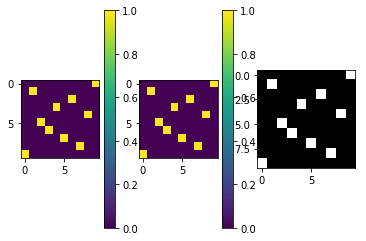

('INPUT:', [911.0, 802.0, 108.0, 955.0, 323.0, 564.0, 704.0, 784.0, 785.0, 376.0])
('PREDICT:', [376.0, 801.592041015625, 702.514404296875, 323.4739074707031, 784.6851806640625, 109.99593353271484, 953.0894165039062, 564.2262573242188, 783.8629150390625, 911.0])
('TRUE   :', [376.0, 802.0, 704.0, 323.0, 785.0, 108.0, 955.0, 564.0, 784.0, 911.0])
('METRIC:', array([9, 1, 6, 4, 8, 2, 3, 5, 7, 0]))
('NORM:', array([9, 1, 6, 4, 8, 2, 3, 5, 7, 0]))


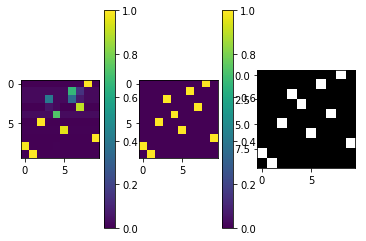

('INPUT:', [459.0, 227.0, 724.0, 79.0, 766.0, 495.0, 669.0, 34.0, 449.0, 833.0])
('PREDICT:', [448.99993896484375, 545.8844604492188, 365.3575744628906, 61.3803825378418, 678.2564697265625, 723.665283203125, 494.9255676269531, 832.1514282226562, 461.2630310058594, 227.0])
('TRUE   :', [449.0, 669.0, 79.0, 766.0, 34.0, 724.0, 495.0, 833.0, 459.0, 227.0])
('METRIC:', array([8, 6, 3, 4, 7, 2, 5, 9, 0, 1]))
('NORM:', array([8, 6, 3, 4, 7, 2, 5, 9, 0, 1]))


In [12]:

import matplotlib.pyplot as plt
np.set_printoptions(suppress=True,threshold=500000)
p = model.predict(val)
print("VAL_MSE:", float(K.eval(K.mean(K.pow(p - val_target, 2)))))
for x,a,b in zip(val[:5]*1000,p[:5]*1000.0,val_target[:5]*1000.0):
    #print(c.shape)
    #plt.imshow(c)
    #plt.colorbar()
    #lt.show()
    print("INPUT:",flatten(x[:,0].tolist()))
    print("PREDICT:",flatten(a[:,0].tolist()))
    print("TRUE   :",flatten(b[:,0].tolist()))
#print([np.concatenate(list(x), axis=-1) for ])
#print(target)


('VAL_MSE:', 0.018438392943366057)
('INPUT:', [926.0, 697.0, 377.0, 809.0, 333.0, 697.0, 886.0, 875.0, 272.0, 213.0, 312.0, 678.0, 426.0, 127.0, 556.0, 192.0, 887.0, 989.0, 229.0, 245.0, 168.0, 949.0, 56.0, 956.0, 805.0, 12.0, 716.0, 786.0, 363.0, 822.0, 7.0, 592.0, 752.0, 921.0, 242.0, 232.0, 786.0, 858.0, 685.0, 639.0, 762.0, 883.0, 965.0, 556.0, 294.0, 174.0, 568.0, 810.0, 505.0, 719.0, 755.0, 607.0, 365.0, 454.0, 156.0, 132.0, 238.0, 402.0, 452.0, 882.0, 663.0, 326.0, 621.0, 583.0, 52.0, 528.0, 992.0, 195.0, 786.0, 256.0, 463.0, 155.0, 300.0, 606.0, 338.0, 583.0, 955.0, 149.0, 81.0, 905.0, 244.0, 560.0, 896.0, 945.0, 938.0, 447.0, 8.0, 484.0, 500.0, 132.0, 926.0, 382.0, 856.0, 901.0, 987.0, 23.0, 357.0, 982.0, 143.0, 498.0, 316.0, 354.0, 559.0, 315.0, 477.0, 753.0, 393.0, 160.0, 51.0, 206.0, 679.0, 385.0, 534.0, 339.0, 46.0, 362.0, 760.0, 336.0, 587.0, 398.0, 157.0, 515.0, 750.0, 17.0, 153.0, 779.0, 717.0, 921.0, 986.0, 538.0, 143.0, 120.0, 667.0, 346.0, 573.0, 878.0, 777.0, 607.0,

In [ ]:
'''CUSTOM 50 ints mapped to [0,1]
('VAL_MSE:', 0.001569600218234435)
('PREDICT:', [14.08072566986084, 24.556095123291016, 28.295637130737305, 30.411785125732422, 33.13698196411133, 37.32411193847656, 46.1008186340332, 53.2075080871582, 63.4344596862793, 72.48200988769531, 85.3075942993164, 93.4632568359375, 98.74871826171875, 108.7425765991211, 110.91658020019531, 123.70269775390625, 134.5385284423828, 143.88876342773438, 159.08541870117188, 181.8461456298828, 190.42434692382812, 203.7500457763672, 220.6626434326172, 239.72796630859375, 245.00320434570312, 246.1892547607422, 236.80545043945312, 245.6599884033203, 232.46725463867188, 239.04486083984375, 245.08265686035156, 248.84344482421875, 264.63299560546875, 285.3381652832031, 289.361083984375, 299.7632751464844, 313.9530944824219, 323.9080505371094, 322.595947265625, 334.1806335449219, 332.671875, 323.8444519042969, 335.371337890625, 339.9270935058594, 359.6188659667969, 392.69171142578125, 423.1754455566406, 479.6092224121094, 546.0584716796875, 667.3662719726562])
('TRUE   :', [2.0, 15.0, 30.0, 33.0, 45.0, 51.0, 63.0, 65.0, 71.0, 76.0, 81.0, 91.0, 92.0, 93.0, 98.0, 103.0, 115.0, 127.0, 163.0, 188.0, 192.0, 193.0, 208.0, 223.0, 225.0, 229.0, 238.0, 247.0, 257.0, 263.0, 265.0, 272.0, 277.0, 282.0, 291.0, 293.0, 297.0, 313.0, 347.0, 350.0, 350.0, 368.0, 385.0, 410.0, 426.0, 436.0, 446.0, 450.0, 452.0, 484.0])
('PREDICT:', [17.798559188842773, 33.463016510009766, 39.10608673095703, 43.00112533569336, 44.50833511352539, 48.93029022216797, 58.13621139526367, 64.9529037475586, 75.26228332519531, 85.29837799072266, 102.46138763427734, 113.64612579345703, 124.90634155273438, 140.658935546875, 146.15133666992188, 162.67030334472656, 172.6062469482422, 179.36094665527344, 194.64930725097656, 214.78004455566406, 219.95840454101562, 231.04476928710938, 246.4239959716797, 264.68646240234375, 269.5362548828125, 272.99102783203125, 266.89630126953125, 275.0792236328125, 260.5761413574219, 267.4671936035156, 272.8695373535156, 275.08282470703125, 289.3886413574219, 310.0047302246094, 313.9212951660156, 327.7631530761719, 342.7054748535156, 356.8041076660156, 354.9676208496094, 364.4736328125, 364.2120361328125, 353.3575744628906, 363.51544189453125, 365.5188903808594, 381.6290283203125, 414.7137756347656, 445.9398498535156, 501.1640930175781, 568.592529296875, 690.3679809570312])
('TRUE   :', [24.0, 35.0, 42.0, 46.0, 54.0, 63.0, 67.0, 67.0, 68.0, 71.0, 119.0, 124.0, 148.0, 151.0, 151.0, 153.0, 162.0, 174.0, 180.0, 212.0, 214.0, 216.0, 219.0, 234.0, 243.0, 247.0, 257.0, 266.0, 274.0, 275.0, 282.0, 289.0, 294.0, 299.0, 320.0, 334.0, 343.0, 359.0, 387.0, 390.0, 393.0, 403.0, 404.0, 420.0, 427.0, 445.0, 477.0, 485.0, 491.0, 496.0])
('PREDICT:', [15.987208366394043, 22.936832427978516, 24.929330825805664, 23.940183639526367, 26.281198501586914, 28.679780960083008, 35.26726150512695, 41.234291076660156, 49.22452926635742, 57.713165283203125, 69.93475341796875, 81.98285675048828, 92.2459487915039, 106.03779602050781, 111.96952056884766, 127.2327880859375, 139.74241638183594, 149.53489685058594, 164.30023193359375, 187.7772979736328, 195.0567169189453, 207.03494262695312, 223.97085571289062, 243.4896697998047, 249.49842834472656, 252.11972045898438, 244.68350219726562, 256.1998596191406, 243.84954833984375, 249.20632934570312, 256.2884826660156, 260.6770935058594, 276.7026062011719, 297.2806091308594, 304.63134765625, 313.7358703613281, 328.58837890625, 340.76373291015625, 339.2470703125, 354.3557434082031, 352.0670166015625, 342.35394287109375, 349.97125244140625, 354.6605224609375, 372.7105407714844, 405.00885009765625, 434.8564453125, 491.1487121582031, 557.1630859375, 677.7264404296875])
('TRUE   :', [5.0, 7.0, 18.0, 19.0, 22.0, 34.0, 42.0, 46.0, 62.0, 67.0, 73.0, 76.0, 86.0, 91.0, 97.0, 126.0, 129.0, 136.0, 146.0, 188.0, 190.0, 221.0, 225.0, 239.0, 240.0, 244.0, 252.0, 267.0, 269.0, 280.0, 286.0, 288.0, 302.0, 305.0, 309.0, 311.0, 326.0, 327.0, 328.0, 346.0, 360.0, 376.0, 380.0, 383.0, 440.0, 441.0, 466.0, 471.0, 492.0, 498.0])
('PREDICT:', [11.489262580871582, 21.53560447692871, 26.528684616088867, 31.471845626831055, 35.73295593261719, 39.66163635253906, 47.582332611083984, 53.18813705444336, 61.857879638671875, 68.80801391601562, 79.4161148071289, 87.07296752929688, 95.16581726074219, 105.8012924194336, 109.74620819091797, 124.03075408935547, 132.88026428222656, 140.9227752685547, 157.01925659179688, 179.16712951660156, 188.27259826660156, 203.6239776611328, 223.47901916503906, 243.16221618652344, 251.58175659179688, 261.0755615234375, 258.14581298828125, 272.0953369140625, 260.53173828125, 268.5575866699219, 278.5340881347656, 282.1059875488281, 296.9542541503906, 322.8467712402344, 329.10272216796875, 339.53363037109375, 352.66217041015625, 367.4928283691406, 364.8778076171875, 375.7081604003906, 372.43109130859375, 359.92608642578125, 368.53411865234375, 367.78338623046875, 379.3459777832031, 407.968017578125, 437.1671142578125, 491.94964599609375, 557.7061767578125, 677.7650146484375])
('TRUE   :', [7.0, 18.0, 23.0, 35.0, 39.0, 58.0, 58.0, 58.0, 71.0, 72.0, 83.0, 93.0, 95.0, 105.0, 106.0, 107.0, 116.0, 118.0, 119.0, 121.0, 146.0, 152.0, 202.0, 209.0, 215.0, 243.0, 263.0, 264.0, 295.0, 306.0, 316.0, 327.0, 340.0, 345.0, 349.0, 358.0, 362.0, 363.0, 385.0, 387.0, 392.0, 407.0, 417.0, 418.0, 420.0, 452.0, 470.0, 480.0, 488.0, 497.0])
('PREDICT:', [7.55507755279541, 16.36643409729004, 23.913782119750977, 32.16132354736328, 38.57605743408203, 45.92708206176758, 59.185604095458984, 69.88860321044922, 86.69200134277344, 104.30606079101562, 125.08720397949219, 140.39102172851562, 150.21304321289062, 162.2456512451172, 164.09713745117188, 178.21006774902344, 189.20077514648438, 200.25869750976562, 219.09280395507812, 244.91690063476562, 254.4220733642578, 267.34674072265625, 286.1042785644531, 302.54522705078125, 306.969482421875, 310.17462158203125, 300.88873291015625, 308.5691833496094, 298.9417724609375, 308.135498046875, 319.60076904296875, 323.387939453125, 340.26904296875, 363.6531066894531, 365.5494689941406, 374.900634765625, 384.005126953125, 393.2171630859375, 386.8927917480469, 394.5536193847656, 391.1708984375, 380.7538757324219, 390.9411315917969, 392.7253723144531, 409.16033935546875, 441.95941162109375, 472.1098327636719, 531.0437622070312, 600.9254760742188, 717.796875])
('TRUE   :', [0.0, 2.0, 4.0, 28.0, 51.0, 67.0, 83.0, 88.0, 92.0, 98.0, 111.0, 121.0, 132.0, 134.0, 154.0, 185.0, 191.0, 194.0, 198.0, 226.0, 253.0, 263.0, 279.0, 284.0, 290.0, 304.0, 311.0, 313.0, 317.0, 340.0, 354.0, 374.0, 378.0, 387.0, 392.0, 396.0, 399.0, 403.0, 406.0, 407.0, 417.0, 420.0, 420.0, 458.0, 459.0, 469.0, 473.0, 476.0, 484.0, 492.0])'''

In [62]:
best8 = model #sparsity =.125, injection = .2

In [63]:
best10 = model #sparsity =.125, injection = .2

In [68]:
best10.save_weights("/bigdata/shared/Delphes/sorter_weights/Best10_800x3.h5")
model.to_json()

In [63]:
best8.save_weights("/bigdata/shared/Delphes/sorter_weights/Best8_800x3.h5")
model.to_json()

'{"class_name": "Model", "keras_version": "1.2.2", "config": {"layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 8, 1], "input_dtype": "float32", "sparse": false, "name": "input"}, "inbound_nodes": [], "name": "input"}, {"class_name": "Flatten", "config": {"trainable": true, "name": "flatten_12"}, "inbound_nodes": [[["input", 0, 0]]], "name": "flatten_12"}, {"class_name": "Dense", "config": {"W_constraint": null, "b_constraint": null, "name": "dense_36", "activity_regularizer": null, "trainable": true, "init": "glorot_uniform", "bias": true, "input_dim": 8, "b_regularizer": null, "W_regularizer": null, "activation": "relu", "output_dim": 800}, "inbound_nodes": [[["flatten_12", 0, 0]]], "name": "dense_36"}, {"class_name": "Dense", "config": {"W_constraint": null, "b_constraint": null, "name": "dense_37", "activity_regularizer": null, "trainable": true, "init": "glorot_uniform", "bias": true, "input_dim": 800, "b_regularizer": null, "W_regularizer": null, "act

In [67]:
print(model)
print(best10)

In [165]:
sweep = [0.0,0.00001,0.0001,0.001,0.01,0.025,0.1,1.0]
mses = []
models = []
runs = {}
for n in range(1):
    for sp in [0.0]:#sweep:#[0.0]:
        model = buildLearnMetric()
        #model = buildModel(sparsity_coeff= .125, injection_coeff= .2)
        mse_vals = []
        for i in range(100):
            #model.fit(inp, np.linalg.norm(inp,axis=-1,keepdims=True), nb_epoch=1,batch_size=100)
            model.fit(inp, [target,inp_t_target,np.sum(target,axis=-1)], nb_epoch=1,batch_size=100)
            #model.fit(inp, [target,inp_t_target], nb_epoch=1,batch_size=100)
            #model.fit(inp,target, nb_epoch=1,batch_size=100)
            #model.fit(inp,inp_t_target, nb_epoch=1,batch_size=100)
            p,u,met = model.predict(val)
            #p,u = model.predict(val)
            val_mse = float(K.eval(K.mean(K.pow(p - val_target, 2))))
            mse_vals.append(val_mse )
            print("VAL_MSE:", val_mse)
        models.append(model)
        #val_mse = np.random.randint(size=1,low=0,high=100)[0]#(min(mse_vals))
        #print(runs.get(sp,[]))
        runs[sp] = runs.get(sp,[]) + [min(mse_vals)]
print(runs)
import json
json.dump(runs, open(os.path.abspath("/home/dweitekamp/custom_out1.txt"),'w'))

((10, 800), (800,))
((800, 800), (800,))
((800, 800), (800,))
((800, 100), (100,))
10


In [281]:
rand = np.random.random((2,8,1))

In [282]:
a,b = model.predict(rand)

In [283]:
c,d = best8.predict(rand)

In [284]:
print(a-c)
print(b-d)

[[[ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]]

 [[ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]]]
[[[ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]]

 [[ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]]]
